## Projet: Implémentez un modéle de scoring

Objectif: Aider la société "Prêt à dépanser, organisme octroyant des crédits à des personnes y ayant difficilement accès, en créant un modèle de classification permettant de prédire la probabilité de défaut d'un client sur un crédit et de pouvoir aider à la prise de décision.

Il s'agit d'un problème de classification supervisée où l'on dispose d'un jeu de données "train" avec target étiquetée et un jeu de test sans la target.

On dispose de 10 jeu de données. Certains concernent les emprunts précédents des clients auprès d'Home Credit d'autres des données provenant d'institutions extérieures. Il s'agit à la fois de données administratives et comportementales.


In [254]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder

## 1. Data imports, cleaning

### 1.1 Import `application_test.csv`

Les principales données de test contenant des informations sur chaque demande de prêt chez Home Credit. Chaque prêt dispose de sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`

In [97]:
test_df = pd.read_csv('../data/application_test.csv')

In [98]:
test_df

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [99]:
# Vérification des doublons dans les identifiants
print("Doublons dans les identifiants:", test_df['SK_ID_CURR'].duplicated().sum())

Doublons dans les identifiants: 0


In [100]:
test_df['SK_ID_CURR'].nunique()

48744

In [101]:
100 * test_df.isna().to_numpy().mean()

np.float64(23.811686761532336)

In [329]:
# Valeurs manquants dans le jeu de données train :

miss_val_table_test = missing_values_table(test_df)

Le dataframe a 121 columns.
Et il y a 64 colonnes ayant des valeurs manquantes.


In [330]:
miss_val_table_test.head()

,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4


In [331]:
display(miss_val_table_test[miss_val_table_test["% of Total Values"]>=50])

,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [332]:
test_df = delete_missing_columns(test_df, threshold=50, col_to_keep=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

In [333]:
test_df["DAYS_EMPLOYED"] = test_df["DAYS_EMPLOYED"].replace(365243, np.nan)

In [334]:
miss_val_table_test = missing_values_table(test_df)

Le dataframe a 92 columns.
Et il y a 36 colonnes ayant des valeurs manquantes.


In [335]:
miss_val_table_test.head()

,Missing Values,% of Total Values
WALLSMATERIAL_MODE,23893,49.0
APARTMENTS_AVG,23887,49.0
APARTMENTS_MEDI,23887,49.0
APARTMENTS_MODE,23887,49.0
HOUSETYPE_MODE,23619,48.5


In [336]:
test_df["CODE_GENDER"].value_counts(dropna=False)

CODE_GENDER
F    32678
M    16066
Name: count, dtype: int64

In [338]:
test_df["ORGANIZATION_TYPE"].value_counts(dropna=False)

ORGANIZATION_TYPE
Business Entity Type 3    10840
XNA                        9274
Self-employed              5920
Other                      2707
Medicine                   1716
Government                 1508
Business Entity Type 2     1479
Trade: type 7              1303
School                     1287
Construction               1039
Kindergarten               1038
Business Entity Type 1      887
Transport: type 4           884
Trade: type 3               578
Military                    530
Industry: type 9            499
Industry: type 3            489
Security                    472
Transport: type 2           448
Police                      441
Housing                     435
Industry: type 11           416
Bank                        374
Security Ministries         341
Services                    302
Postal                      294
Agriculture                 292
Restaurant                  284
Trade: type 2               242
University                  221
Industry: type 7      

In [339]:
test_df["ORGANIZATION_TYPE"] = np.where(test_df["ORGANIZATION_TYPE"] == "XNA", np.nan, test_df["ORGANIZATION_TYPE"])

In [ ]:
# Feature engineering (identique au train)
test_df["INCOME_PER_PERSON"] = test_df["AMT_INCOME_TOTAL"] / test_df["CNT_FAM_MEMBERS"]
test_df["ANNUITY_AS_INCOME_PERC"] = test_df["AMT_ANNUITY"] / test_df["AMT_INCOME_TOTAL"]
test_df["PAYMENT_RATE"] = test_df["AMT_ANNUITY"] / test_df["AMT_CREDIT"]
test_df["CREDIT_INCOME_RATIO"] = test_df["AMT_CREDIT"] / test_df["AMT_INCOME_TOTAL"]
test_df["DOWN_PAYMENT"] = test_df["AMT_GOODS_PRICE"] - test_df["AMT_CREDIT"]

test_df["YEARS_BIRTH"] = - test_df["DAYS_BIRTH"] / 365
test_df["YEARS_EMPLOYED"] = - test_df["DAYS_EMPLOYED"] / 365

test_df["EMPLOYMENT_AGE_RATIO"] = test_df["YEARS_EMPLOYED"] / test_df["YEARS_BIRTH"]

# Drop colonnes sources comme train
test_df.drop(["DAYS_BIRTH", "DAYS_EMPLOYED"], axis=1, inplace=True)

In [341]:
# Alignement final
train_cols = [c for c in train_df.columns if c != "TARGET"]
test_df = test_df.reindex(columns=train_cols)

print("train_df shape:", train_df.shape)
print("test_df shape :", test_df.shape)
print("TARGET in test ?", "TARGET" in test_df.columns)

train_df shape: (307505, 88)
test_df shape : (48744, 87)
TARGET in test ? False


### 1.2 Import `application_train.csv`

Les principales données d'entraînement contenant des informations sur chaque demande de prêt chez Home Credit. Chaque prêt dispose de sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. 
Les données d'entraînement sont accompagnées de la cible indiquant

0 : le prêt a été remboursé 

1 : le prêt n'a pas été remboursé

In [194]:
train= pd.read_csv('../data/application_train.csv')

In [195]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
train_df = train.copy()

In [197]:
# Vérification des doublons dans les identifiants
print("Doublons dans les identifiants:", train_df['SK_ID_CURR'].duplicated().sum())

Doublons dans les identifiants: 0


In [198]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [199]:
train_df['TARGET'].value_counts(normalize = True) * 100

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

In [200]:
target_counts = train_df['TARGET'].value_counts()

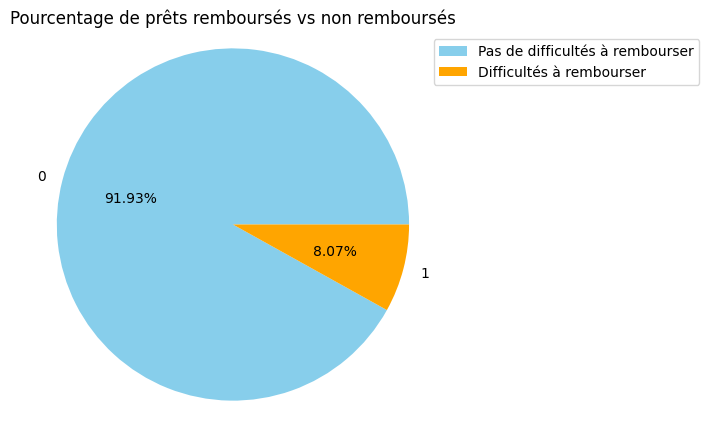

In [201]:
plt.figure(figsize=(5,5))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.2f%%', colors=['skyblue', 'orange'])
plt.title('Pourcentage de prêts remboursés vs non remboursés')
plt.legend(labels=['Pas de difficultés à rembourser', 'Difficultés à rembourser'], loc='best', bbox_to_anchor=(1,1))
plt.axis('equal') 

plt.show()

**Le jeu de donées présente un fort déséquilibre de classe au niveau de la target**

Une methode tel que SMOTE, Class Weight, undersampling devra être utilisée afin de pas biaiser les résultats de l'algorithme de scoring.

In [202]:
# Nombre de chaque type de colonne
train_df.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

### Point sur les valeurs manquantes

In [203]:
# Création d'une fonction permettant de visualiser les valeurs manquantes :

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table = mis_val_table[
            mis_val_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Le dataframe a " + str(df.shape[1]) + " columns.\n"      
            "Et il y a " + str(mis_val_table.shape[0]) +
              " colonnes ayant des valeurs manquantes.")
        
        # Return the dataframe with missing information
        return mis_val_table

In [204]:
# Valeurs manquants dans le jeu de données train :

miss_val_table_train = missing_values_table(train_df)

Le dataframe a 122 columns.
Et il y a 67 colonnes ayant des valeurs manquantes.


In [205]:
miss_val_table_train[miss_val_table_train["% of Total Values"]>=50].shape[0]

41

Il y a 41 colonnes ayant 50% ou plus de valeurs manquantes

In [206]:
display(miss_val_table_train[miss_val_table_train["% of Total Values"]>=50])

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Le taux de valeurs manquants assez important concerne principalement des informations sur le lieu d'habiitation des clients.

<Axes: >

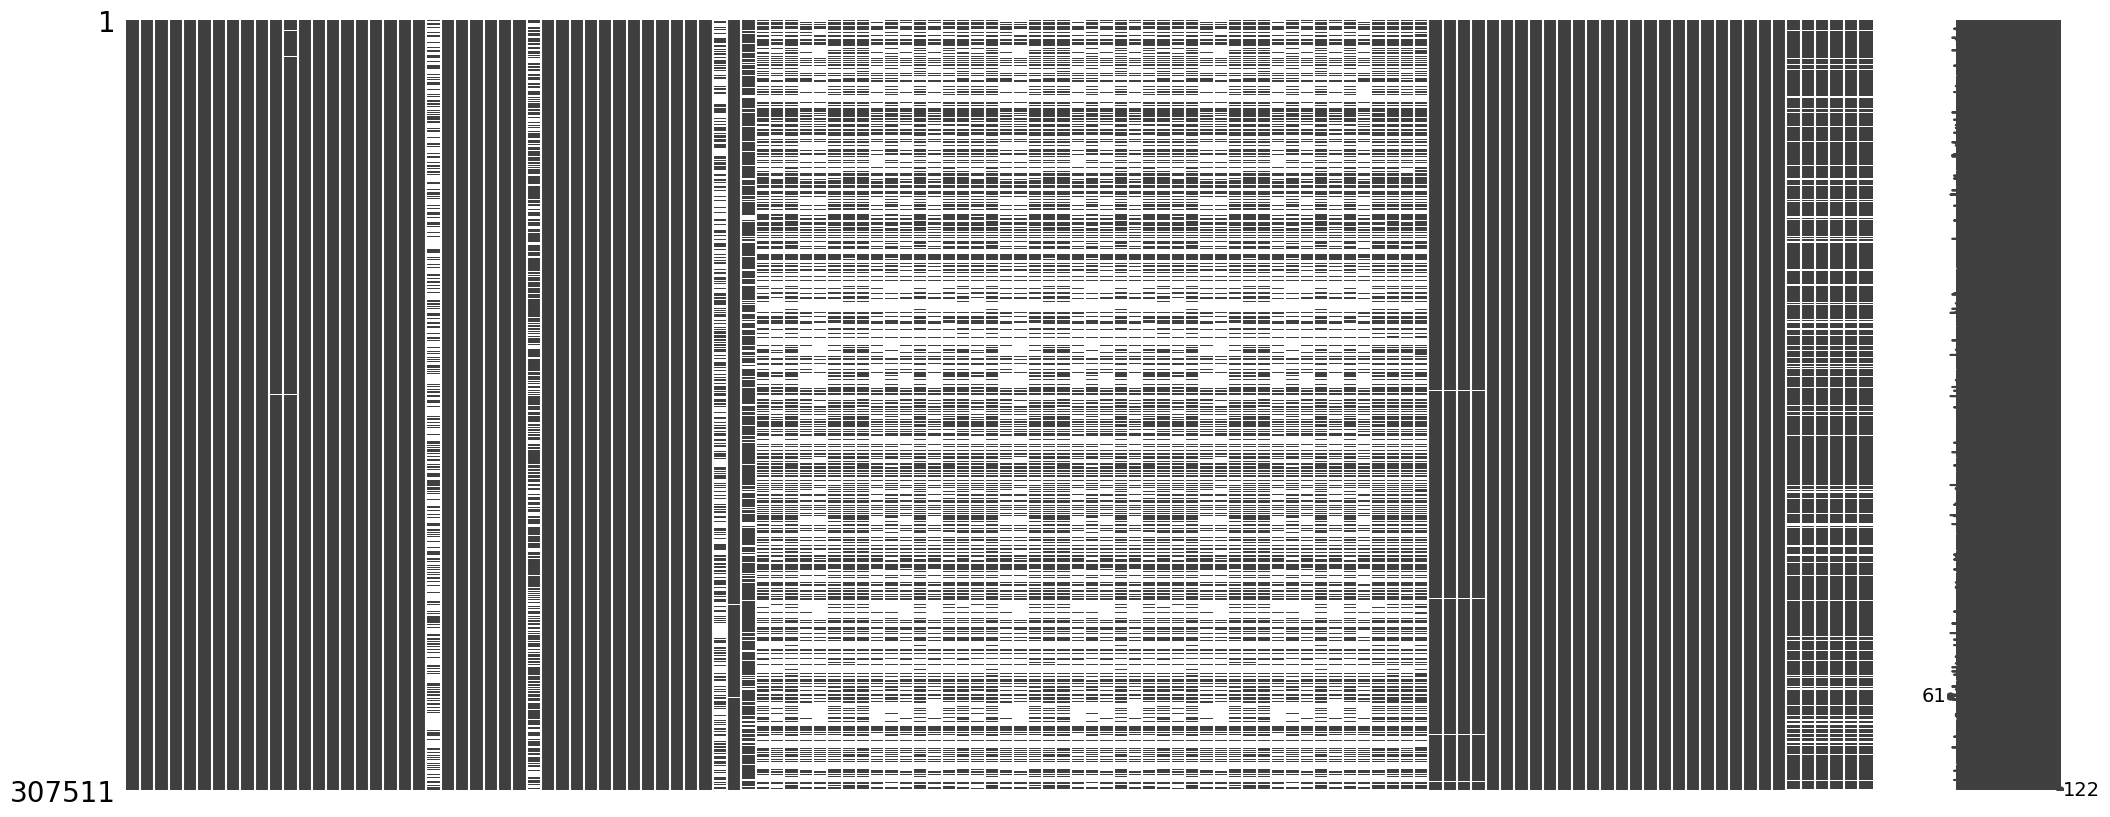

In [208]:
msno.matrix(train_df)

<Axes: >

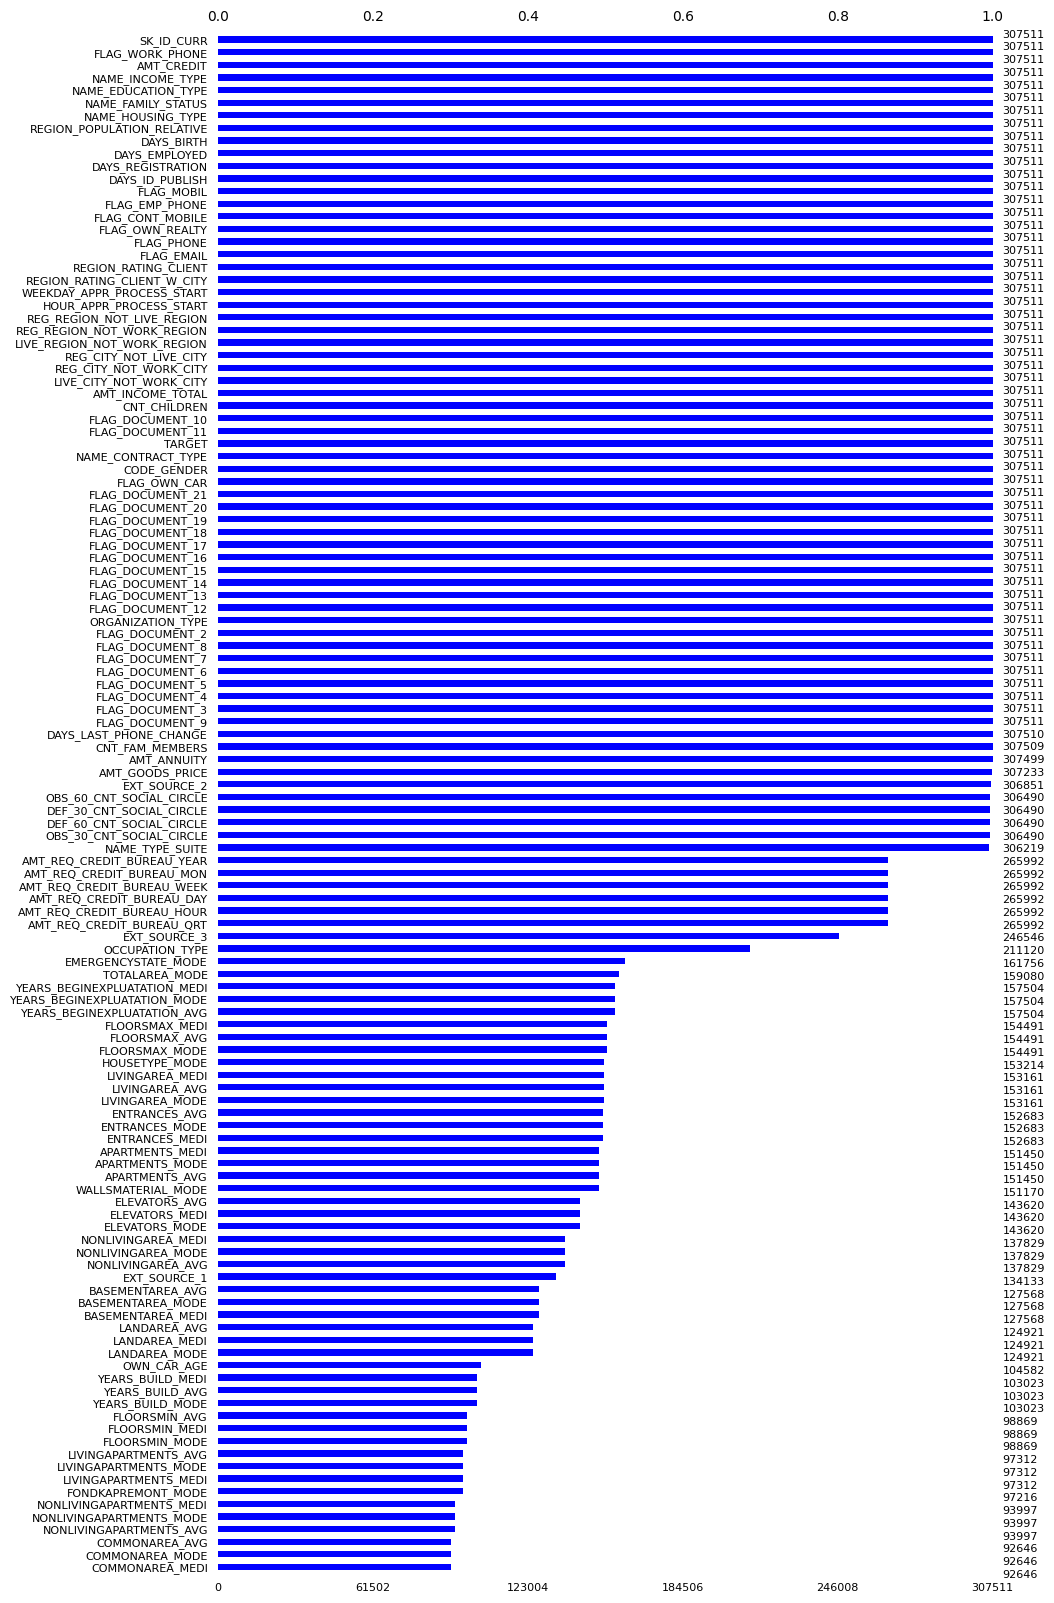

In [209]:
msno.bar(train_df, figsize=(10,20), fontsize=8, sort='ascending', color='blue')

In [207]:
def delete_missing_columns(df, threshold=50, col_to_keep=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    """
    Fonction qui supprime les colonnes ayant un pourcentage de valeurs manquantes supérieur au seuil spécifié,
    sauf celles spécifiées dans col_to_keep.
    
    Paramètres:
    df (DataFrame): Le DataFrame à traiter.
    threshold (float): Le pourcentage seuil de valeurs manquantes pour supprimer une colonne.
    col_to_keep (list): Liste des colonnes à conserver même si elles dépassent le seuil.
    
    Retourne:
    DataFrame: Le DataFrame avec les colonnes supprimées.
    """
    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    missing_percentages = (df.isnull().sum() / len(df)) * 100
    # Identifier les colonnes à supprimer
    columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist()
    # Retirer les colonnes à conserver
    columns_to_drop = [col for col in columns_to_drop if col not in col_to_keep]
    # Supprimer les colonnes
    df_cleaned = df.drop(columns=columns_to_drop)
    return df_cleaned

In [210]:
train_df = delete_missing_columns(train_df, threshold=50, col_to_keep=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

In [211]:
miss_val_table_train = missing_values_table(train_df)

Le dataframe a 82 columns.
Et il y a 27 colonnes ayant des valeurs manquantes.


In [212]:
miss_val_table_train.head()

,Missing Values,% of Total Values
EXT_SOURCE_1,173378,56.4
FLOORSMAX_MEDI,153020,49.8
FLOORSMAX_AVG,153020,49.8
FLOORSMAX_MODE,153020,49.8
YEARS_BEGINEXPLUATATION_AVG,150007,48.8


In [213]:
# La proportion globale de valeurs manquantes 
100 * train_df.isna().to_numpy().mean()

np.float64(7.096490143402366)

### Variables atypiques/aberrantes

In [214]:
# Dataframe des variables numériques
numerical_columns_train_df = train_df.select_dtypes(exclude=['object'])

In [215]:
numerical_columns_train_df.iloc[:, :].describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


In [216]:
# Compter combien de fois on voit la valeur 365243
(numerical_columns_train_df["DAYS_EMPLOYED"] == 365243).mean()

np.float64(0.18007160719453938)

In [217]:
train_df["DAYS_EMPLOYED"] = train_df["DAYS_EMPLOYED"].replace(365243, np.nan)

Text(0.5, 0, 'Days Employment')

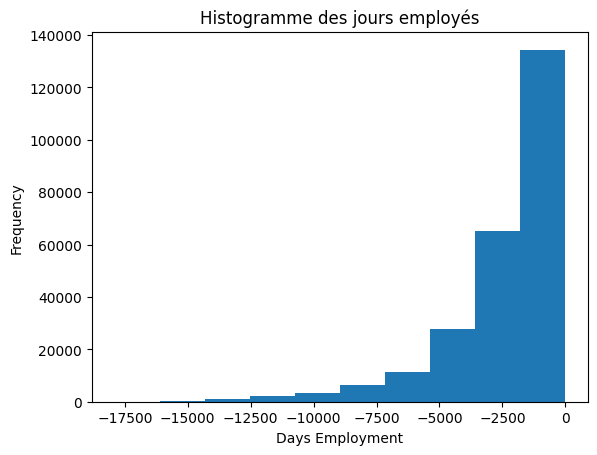

In [218]:
train_df['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme des jours employés');
plt.xlabel('Days Employment')

In [219]:
(train_df['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

L'âge maximal est 69 et le minimal es 20 ans, il n'y a pas d'outliers.

<Axes: >

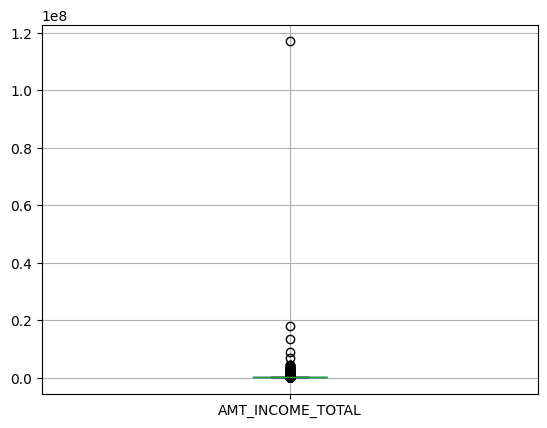

In [220]:
train_df[['AMT_INCOME_TOTAL']].boxplot()

In [221]:
train_df.loc[train_df['AMT_INCOME_TOTAL'].argmax(), ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'CODE_GENDER', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE']]

SK_ID_CURR                                    114967
AMT_INCOME_TOTAL                         117000000.0
CODE_GENDER                                        F
OCCUPATION_TYPE                             Laborers
ORGANIZATION_TYPE             Business Entity Type 3
NAME_EDUCATION_TYPE    Secondary / secondary special
Name: 12840, dtype: object

In [222]:
train_df.loc[train_df['AMT_INCOME_TOTAL'].argmax(), 'AMT_INCOME_TOTAL'] = 11700000

In [223]:
train_df['AMT_INCOME_TOTAL'].sort_values(ascending=False).head()

203693    18000090.0
246858    13500000.0
12840     11700000.0
77768      9000000.0
131127     6750000.0
Name: AMT_INCOME_TOTAL, dtype: float64

<Axes: >

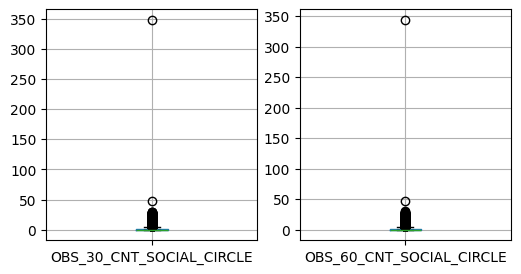

In [224]:
# 348 et 344 semblent très élevés pour 30 CNT et 60 CNT - aberrant (nb of observation of client's social surroundings)
fig, axs = plt.subplots(1,2,figsize=(6,3))

train_df[["OBS_30_CNT_SOCIAL_CIRCLE"]].boxplot(ax=axs[0])
train_df[["OBS_60_CNT_SOCIAL_CIRCLE"]].boxplot(ax=axs[1])

In [225]:
train_df.loc[train_df['OBS_30_CNT_SOCIAL_CIRCLE'].argmax(), ['SK_ID_CURR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']]

SK_ID_CURR                  272071
OBS_30_CNT_SOCIAL_CIRCLE     348.0
OBS_60_CNT_SOCIAL_CIRCLE     344.0
Name: 148403, dtype: object

Les valeurs incohérentes concernent ici le même individu, on le supprime de l'échantillon.

In [226]:
train_df.drop(train_df['OBS_60_CNT_SOCIAL_CIRCLE'].argmax(), axis =0, inplace=True)

Le 'describe' nous montrait une valeur étonnamment élevée pour la variable 'AMT_REQ_CREDIT_BUREAU_QRT', surtout comparé à celle mensuelle ou annuelle.

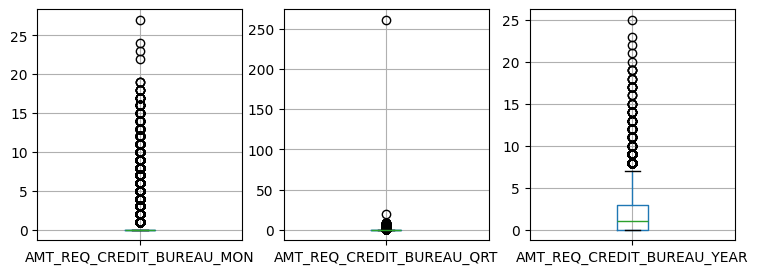

In [227]:
fig, axs = plt.subplots(1,3, figsize=(9, 3))

train_df[['AMT_REQ_CREDIT_BUREAU_MON']].boxplot(ax=axs[0])
train_df[['AMT_REQ_CREDIT_BUREAU_QRT']].boxplot(ax=axs[1])
train_df[['AMT_REQ_CREDIT_BUREAU_YEAR']].boxplot(ax=axs[2])
plt.show()

In [228]:
train_df.drop(train_df['AMT_REQ_CREDIT_BUREAU_QRT'].argmax(), axis = 0, inplace = True)
# Le 'describe' nous montrait une valeur étonnamment élevée pour la variable 'AMT_REQ_CREDIT_BUREAU_QRT', surtout comparé à celle mensuelle ou annuelle.

In [229]:
# Dataframe des variables catégorielles
categorical_columns_train_df = train_df.select_dtypes(include=['object'])


In [230]:
categorical_columns_train_df.describe().T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307509,2,Cash loans,278231
CODE_GENDER,307509,3,F,202447
FLAG_OWN_CAR,307509,2,N,202923
FLAG_OWN_REALTY,307509,2,Y,213310
NAME_TYPE_SUITE,306217,7,Unaccompanied,248525
NAME_INCOME_TYPE,307509,8,Working,158773
NAME_EDUCATION_TYPE,307509,5,Secondary / secondary special,218390
NAME_FAMILY_STATUS,307509,6,Married,196431
NAME_HOUSING_TYPE,307509,6,House / apartment,272866
OCCUPATION_TYPE,211119,18,Laborers,55186


In [231]:
train_df["CODE_GENDER"].value_counts(dropna=False)

CODE_GENDER
F      202447
M      105058
XNA         4
Name: count, dtype: int64

In [232]:
train_df = train_df[train_df['CODE_GENDER'] != 'XNA']

In [233]:
# Y a-t-il d'autres colonnes ou XNA est indiqué ?

columns_with_XNA = []

for col in train_df.columns:
    if 'XNA' in train_df[col].values:
        columns_with_XNA.append(col)

print("Colonnes contenant 'XNA' :", columns_with_XNA)

Colonnes contenant 'XNA' : ['ORGANIZATION_TYPE']


In [234]:
train_df['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity Type 3    67991
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2340
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

Transformons les données XNA en 'unknown'

In [235]:
train_df['ORGANIZATION_TYPE'] = np.where(train_df['ORGANIZATION_TYPE'] == 'XNA', np.nan, train_df['ORGANIZATION_TYPE'])

### Corrélations

In [236]:
correlations = numerical_columns_train_df.corr()['TARGET'].sort_values()

In [237]:
# Affichage des correlations positives et négatives avec la TARGET 
print('Correlations négatives avec la TARGET:\n\n', correlations.tail(10))
print('\nCorrelations positives avec la TARGET :\n\n', correlations.head(10))

Correlations négatives avec la TARGET:

 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Correlations positives avec la TARGET :

 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
TOTALAREA_MODE               -0.032596
Name: TARGET, dtype: float64


Regardons certaines des corrélations les plus significatives :

La corrélation DAYS_BIRTH est la plus positive.

In [238]:
train_df['DAYS_BIRTH'] = abs(train_df['DAYS_BIRTH'])
print("Corrélation entre l'âge du client au moment du prêt et la TARGET :", train_df['DAYS_BIRTH'].corr(train_df['TARGET']))

Corrélation entre l'âge du client au moment du prêt et la TARGET : -0.07824390264978949


Plus les clients vieillissent, plus ils ont tendance à rembourser leurs prêts dans les délais.


In [239]:
# Extraire les variables les plus corrélées avec la cible et afficher les corrélations :
ext_data = train_df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155319,-0.160474,-0.178927,-0.078244
EXT_SOURCE_1,-0.155319,1.000000,0.213979,0.186843,0.600619
EXT_SOURCE_2,-0.160474,0.213979,1.000000,0.109183,0.092004
EXT_SOURCE_3,-0.178927,0.186843,0.109183,1.000000,0.205463
DAYS_BIRTH,-0.078244,0.600619,0.092004,0.205463,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

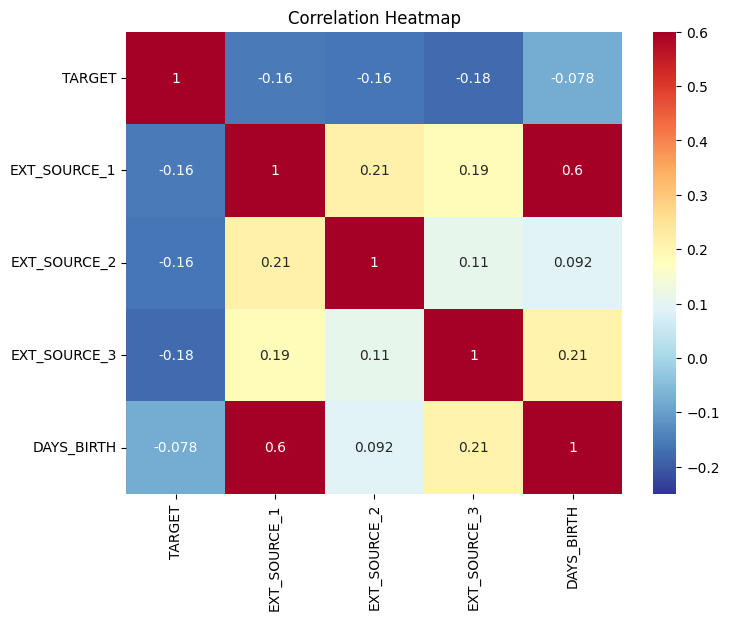

In [240]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

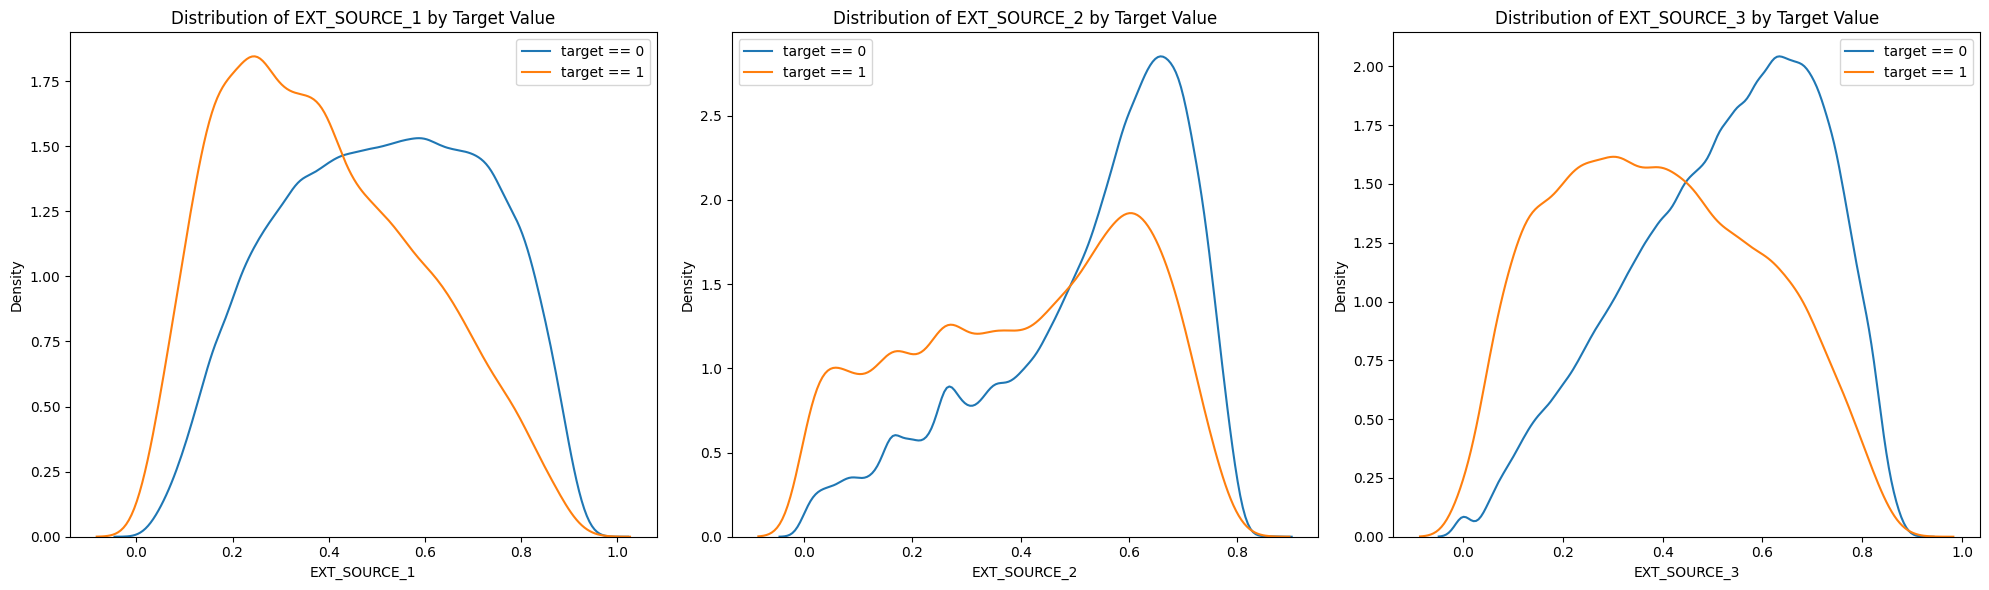

In [241]:
plt.figure(figsize = (20, 6))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(1, 3, i + 1)
    # plot repaid loans
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title(f'Distribution of {source} by Target Value')
    plt.xlabel(f'{source}'); plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

Selon la table de description des variablesles variables EXT_SOURCE sont une "normalized score from external data source". Peut être un scoring crédit établi à partir de diverses sources de données externes. Plus ce score est élévé, moins on a de risque

Les trois caractéristiques EXT_SOURCE ont une corrélation négative avec la cible, ce qui indique que plus la valeur de EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également constater que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'âge du client est peut-être l'un des facteurs pris en compte dans ce score.

### Création de features

In [242]:
# revenu par personne dans le foyer
train_df["INCOME_PER_PERSON"] = train_df["AMT_INCOME_TOTAL"] / train_df["CNT_FAM_MEMBERS"]

# ratio annuités / revenu
train_df["ANNUITY_AS_INCOME_PERC"] = train_df["AMT_ANNUITY"] / train_df["AMT_INCOME_TOTAL"]

# taux de remboursement par annuité
train_df["PAYMENT_RATE"] = train_df["AMT_ANNUITY"] / train_df["AMT_CREDIT"]

# montant du crédit par rapport au revenu
train_df["CREDIT_INCOME_RATIO"] = train_df["AMT_CREDIT"] / train_df["AMT_INCOME_TOTAL"]

# montant de l'achat financé personnellement
train_df["DOWN_PAYMENT"] = train_df["AMT_GOODS_PRICE"] - train_df["AMT_CREDIT"]


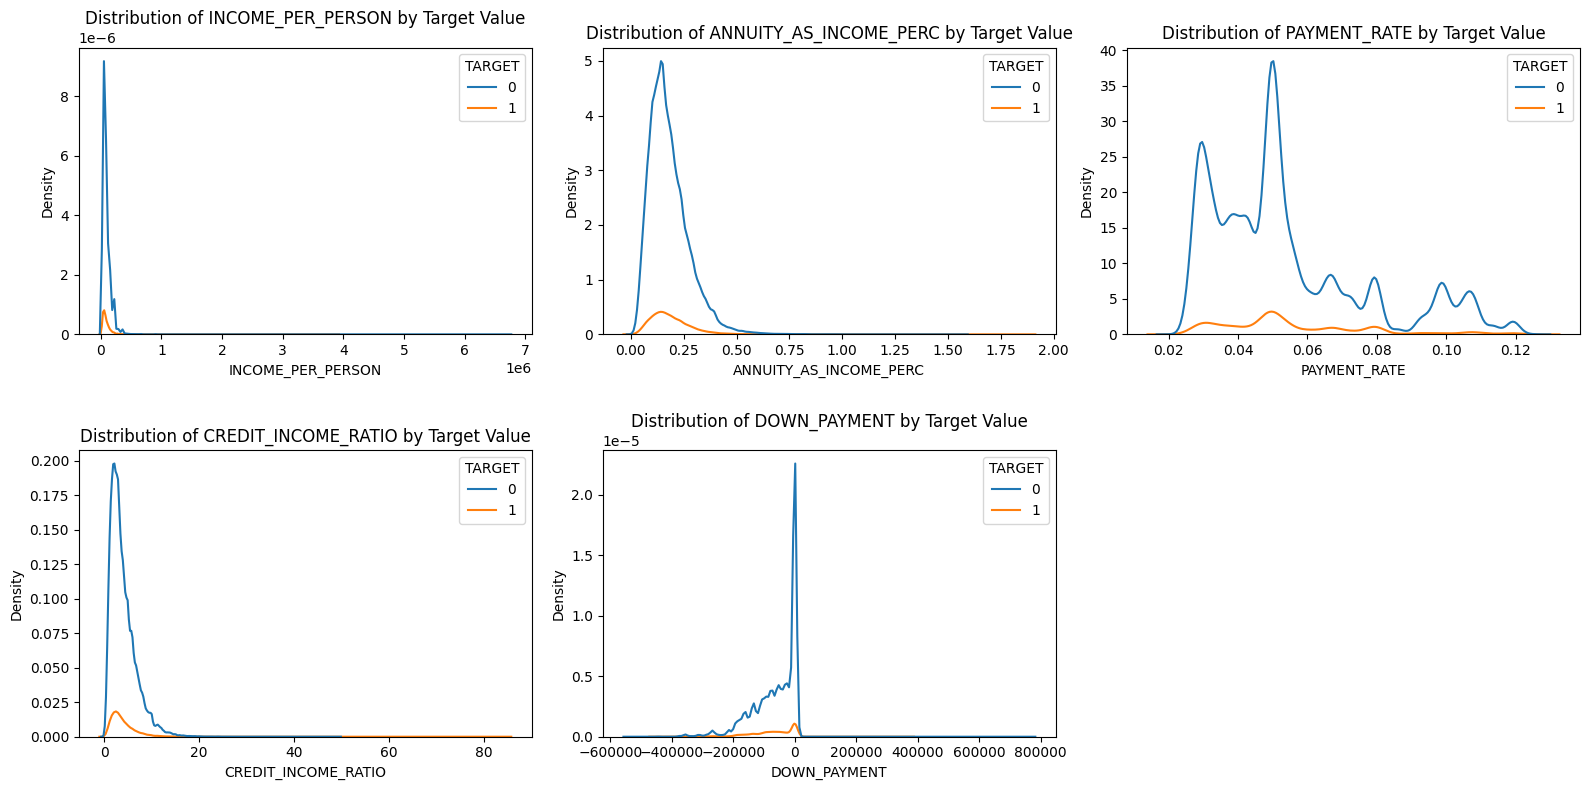

In [243]:
# Corrélation des nouvelles variables avec la target :

plt.figure(figsize = (16, 8))

# on sélectionne les nouvelles variables:
for i, new_feat in enumerate(['INCOME_PER_PERSON', 'ANNUITY_AS_INCOME_PERC', 'PAYMENT_RATE', 'CREDIT_INCOME_RATIO', 'DOWN_PAYMENT']):
    
    # on crée un graphique pour chaque nouvelle variable:
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(data=train_df, x=new_feat, hue='TARGET')
    plt.title(f'Distribution of {new_feat} by Target Value')
    plt.xlabel(f'{new_feat}'); plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

In [244]:
train_df['YEARS_EMPLOYED'] = -train_df['DAYS_EMPLOYED'] / 365

In [245]:
train_df["YEARS_BIRTH"] = - train_df["DAYS_BIRTH"]/365

In [246]:
# part de la durée de vie occupée à travailler
train_df["EMPLOYMENT_AGE_RATIO"] =  train_df["YEARS_EMPLOYED"] / train_df["YEARS_BIRTH"]

In [247]:
# On peut supprimer les variables DAYS_BIRTH et DAYS_EMPLOYED :
train_df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

In [248]:
train_df.shape

(307505, 88)

In [342]:
train_cols = [c for c in train_df.columns if c != "TARGET"]
print(train_cols == list(test_df.columns))

True


### 1.3 Import `bureau_balance.csv`

`bureau_balance.csv` : données mensuelles sur les crédits antérieurs dans le bureau. 
Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

In [137]:
bureau_balance_df = pd.read_csv('../data/bureau_balance.csv')
bureau_balance_df

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [138]:
# check for NaNS

In [139]:
100 * bureau_balance_df.isna().to_numpy().mean()

np.float64(0.0)

In [251]:
bureau_balance_df.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


Concernant la variable 'Months_Balance', les données les + récentes prennent la valeur 0 et les plus anciennes des valeurs négatives de plus en plus faibles.

In [252]:
bureau_balance_df['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

### 1.4 Import `bureau.csv`

`bureau.csv` informations sur les prêts antérieurs du client auprès d'autres institutions financières communiquées à Home Credit. 
Chaque prêt antérieur fait l'objet d'une ligne distincte.

In [140]:
bureau_df = pd.read_csv('../data/bureau.csv')
bureau_df

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


Le jeu de données 'bureau' contient 1 716 428 lignes et 17 colonnes. Il contient donc des informations sur des crédits réalisés par les clients de l'échantillon HomeCredit auprès d'autres institutions financières.

Il s'agira ici de créer des variables par crédits puis par clients, grâce à des aggrégations de types moyennes, max, min, somme ou comptage d'occurrences afin de pouvoir ensuite regrouper ce dataframe avec le dataframe principal.

In [250]:
bureau_df['SK_ID_CURR'].nunique()

305811

In [255]:
def build_bureau_features(bureau_df: pd.DataFrame, bureau_balance_df: pd.DataFrame) -> pd.DataFrame:
    """
    Construit des features au niveau client (SK_ID_CURR) à partir de:
    - bureau_df (niveau crédit externe)
    - bureau_balance_df (niveau mensuel par crédit externe)

    Retour: DataFrame 1 ligne par SK_ID_CURR.
    """

    # -----------------------------
    # 0) On garde seulement ce dont on a besoin (mémoire)
    # -----------------------------
    bureau = bureau_df.copy()
    bb = bureau_balance_df[["SK_ID_BUREAU", "MONTHS_BALANCE", "STATUS"]].copy()

    # -----------------------------
    # 1) Convertir STATUS en DPD + flags
    # -----------------------------
  
    dpd_map = {"0": 0, "1": 15, "2": 45, "3": 75, "4": 105, "5": 135, "C": 0, "X": np.nan}

    bb["BB_DPD"] = bb["STATUS"].astype(str).map(dpd_map).astype("float32")
    bb["BB_UNKNOWN"] = bb["STATUS"].astype(str).eq("X").astype("int8")      # 1 si inconnu
    bb["BB_LATE"] = (bb["BB_DPD"] > 0).astype("int8")                       # 1 si retard

    # -----------------------------
    # 2) Dernier statut (mois le plus récent) par crédit
    # -----------------------------
    # MONTHS_BALANCE: 0 est le plus récent, donc max() donne la dernière ligne
    idx_last = bb.groupby("SK_ID_BUREAU")["MONTHS_BALANCE"].idxmax()

    bb_last = bb.loc[idx_last, ["SK_ID_BUREAU", "STATUS", "BB_DPD"]].copy()
    bb_last.rename(columns={"STATUS": "BB_STATUS_LAST", "BB_DPD": "BB_DPD_LAST"}, inplace=True)

    # -----------------------------
    # 3) Agrégations par crédit externe (SK_ID_BUREAU)
    # -----------------------------
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(
        BB_MONTHS_MIN=("MONTHS_BALANCE", "min"),     # mois le plus ancien (ex -96)
        BB_MONTHS_MAX=("MONTHS_BALANCE", "max"),     # mois le plus récent (souvent 0)
        BB_MONTHS_SIZE=("MONTHS_BALANCE", "size"),   # nb de mois d'historique
        BB_DPD_MEAN=("BB_DPD", "mean"),
        BB_DPD_MAX=("BB_DPD", "max"),
        BB_LATE_RATE=("BB_LATE", "mean"),
        BB_UNKNOWN_RATE=("BB_UNKNOWN", "mean"),
    ).reset_index()

    # Span d’historique en mois
    bb_agg["BB_HISTORY_SPAN"] = (bb_agg["BB_MONTHS_MAX"] - bb_agg["BB_MONTHS_MIN"]).astype("int16")

    # On combine avec le dernier statut
    bb_feats = bb_agg.merge(bb_last, on="SK_ID_BUREAU", how="left")

    # Un peu de ménage mémoire
    del bb, bb_agg, bb_last
    gc.collect()

    # -----------------------------
    # 4) Merge dans bureau (niveau crédit externe)
    # -----------------------------
    bureau = bureau.merge(bb_feats, on="SK_ID_BUREAU", how="left")

    # -----------------------------
    # 5) Compteurs catégoriels interprétables par client
    # -----------------------------
    
    cat_cols = ["CREDIT_ACTIVE", "CREDIT_TYPE"]
    buro_cat = pd.get_dummies(bureau[cat_cols], dummy_na=True).astype("int16")
    buro_cat["SK_ID_CURR"] = bureau["SK_ID_CURR"].values
    buro_cat_counts = buro_cat.groupby("SK_ID_CURR").sum().add_prefix("BURO_CNT_").reset_index()

    # -----------------------------
    # 6) Agrégations numériques par client (SK_ID_CURR)
    # -----------------------------
    num_cols = [
        "DAYS_CREDIT", "DAYS_CREDIT_ENDDATE", "DAYS_CREDIT_UPDATE",
        "CREDIT_DAY_OVERDUE",
        "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT",
        "AMT_CREDIT_SUM_OVERDUE", "AMT_CREDIT_SUM_LIMIT", "AMT_ANNUITY",
        "CNT_CREDIT_PROLONG",
        "BB_MONTHS_SIZE", "BB_HISTORY_SPAN",
        "BB_DPD_MEAN", "BB_DPD_MAX", "BB_DPD_LAST",
        "BB_LATE_RATE", "BB_UNKNOWN_RATE",
    ]
    num_cols = [c for c in num_cols if c in bureau.columns]

    buro_agg = bureau.groupby("SK_ID_CURR").agg(
        BURO_NB_CREDITS=("SK_ID_BUREAU", "count"),
        BURO_NB_CURRENCIES=("CREDIT_CURRENCY", "nunique"),
        **{f"BURO_{c}_MEAN": (c, "mean") for c in num_cols},
        **{f"BURO_{c}_MAX":  (c, "max")  for c in num_cols},
        **{f"BURO_{c}_SUM":  (c, "sum")  for c in ["AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_OVERDUE"] if c in bureau.columns},
    ).reset_index()

    # -----------------------------
    # 7) Active vs Closed 
    # -----------------------------
    def split_agg(df, prefix):
        if df.empty:
            return None
        return df.groupby("SK_ID_CURR").agg(
            **{f"{prefix}_{c}_MEAN": (c, "mean") for c in num_cols},
            **{f"{prefix}_{c}_MAX":  (c, "max")  for c in num_cols},
        ).reset_index()

    active = bureau[bureau["CREDIT_ACTIVE"] == "Active"]
    closed = bureau[bureau["CREDIT_ACTIVE"] == "Closed"]

    active_agg = split_agg(active, "BURO_ACTIVE")
    closed_agg = split_agg(closed, "BURO_CLOSED")

    # -----------------------------
    # 8) Merge final -> 1 ligne par client
    # -----------------------------
    feats = buro_agg.merge(buro_cat_counts, on="SK_ID_CURR", how="left")
    if active_agg is not None:
        feats = feats.merge(active_agg, on="SK_ID_CURR", how="left")
    if closed_agg is not None:
        feats = feats.merge(closed_agg, on="SK_ID_CURR", how="left")

    # Nettoyage mémoire
    del bureau, bb_feats, buro_cat, buro_cat_counts, buro_agg, active, closed, active_agg, closed_agg
    gc.collect()

    return feats

In [256]:
bureau_features = build_bureau_features(bureau_df, bureau_balance_df)

print(bureau_features.shape)
bureau_features.head()

(305811, 135)


,SK_ID_CURR,BURO_NB_CREDITS,BURO_NB_CURRENCIES,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,...,BURO_CLOSED_AMT_CREDIT_SUM_LIMIT_MAX,BURO_CLOSED_AMT_ANNUITY_MAX,BURO_CLOSED_CNT_CREDIT_PROLONG_MAX,BURO_CLOSED_BB_MONTHS_SIZE_MAX,BURO_CLOSED_BB_HISTORY_SPAN_MAX,BURO_CLOSED_BB_DPD_MEAN_MAX,BURO_CLOSED_BB_DPD_MAX_MAX,BURO_CLOSED_BB_DPD_LAST_MAX,BURO_CLOSED_BB_LATE_RATE_MAX,BURO_CLOSED_BB_UNKNOWN_RATE_MAX
0,100001,7,1,-735.000000,82.428571,-93.142857,0.0,NaN,207623.571429,85240.928571,...,0.0,0.0,0.0,52.0,51.0,0.0,0.0,0.0,0.0,0.310345
1,100002,8,1,-874.000000,-349.000000,-499.875000,0.0,1681.029,108131.945625,49156.200000,...,0.0,0.0,0.0,22.0,21.0,7.5,15.0,0.0,0.5,0.187500
2,100003,4,1,-1400.750000,-544.500000,-816.000000,0.0,0.000,254350.125000,0.000000,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,2,1,-867.000000,-488.500000,-532.000000,0.0,0.000,94518.900000,0.000000,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,3,1,-190.666667,439.333333,-54.333333,0.0,0.000,219042.000000,189469.500000,...,0.0,0.0,0.0,13.0,12.0,0.0,0.0,0.0,0.0,0.076923


Le dataset contient des infos pour 305811 clients uniques.

In [257]:
# Verification
# 1 ligne par SK_ID_CURR ?
print("SK_ID_CURR unique ?", bureau_features["SK_ID_CURR"].is_unique)

# nombre de clients couverts
print("nb clients bureau_features:", bureau_features["SK_ID_CURR"].nunique())

SK_ID_CURR unique ? True
nb clients bureau_features: 305811


In [271]:
list(bureau_features.columns)

['SK_ID_CURR',
 'BURO_NB_CREDITS',
 'BURO_NB_CURRENCIES',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
 'BURO_AMT_ANNUITY_MEAN',
 'BURO_CNT_CREDIT_PROLONG_MEAN',
 'BURO_BB_MONTHS_SIZE_MEAN',
 'BURO_BB_HISTORY_SPAN_MEAN',
 'BURO_BB_DPD_MEAN_MEAN',
 'BURO_BB_DPD_MAX_MEAN',
 'BURO_BB_DPD_LAST_MEAN',
 'BURO_BB_LATE_RATE_MEAN',
 'BURO_BB_UNKNOWN_RATE_MEAN',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_UPDATE_MAX',
 'BURO_CREDIT_DAY_OVERDUE_MAX',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MAX',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MAX',
 'BURO_AMT_CREDIT_SUM_LIMIT_MAX',
 'BURO_AMT_ANNUITY_MAX',
 'BURO_CNT_CREDIT_PROLONG_MAX',
 'BURO_BB_MONTHS_SIZE_MAX',
 'BURO_BB_HISTORY_

### 1.5 Import `credit_card_balance.csv`

In [141]:
credit_card_balance_df = pd.read_csv('../data/credit_card_balance.csv')

In [142]:
credit_card_balance_df

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [315]:
credit_card_balance_df.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [317]:
def build_credit_card_features(cc_df: pd.DataFrame) -> pd.DataFrame:
    """
    Construit des features client-level (SK_ID_CURR) à partir de credit_card_balance.
    Étapes :
    1) features au niveau mensuel
    2) agrégation au niveau carte (SK_ID_PREV)
    3) agrégation au niveau client (SK_ID_CURR)

    Retour: DataFrame 1 ligne par SK_ID_CURR
    """

    cc = cc_df.copy()

    # Colonnes utiles
    keep = [
        "SK_ID_CURR", "SK_ID_PREV", "MONTHS_BALANCE",
        "AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL",
        "AMT_DRAWINGS_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT",
        "AMT_TOTAL_RECEIVABLE",
        "CNT_DRAWINGS_CURRENT",
        "SK_DPD", "SK_DPD_DEF",
        "NAME_CONTRACT_STATUS"
    ]
    cols = [c for c in keep if c in cc.columns]
    cc = cc[cols].copy()

    # -----------------------------
    # 1) Feature engineering "mensuel" (ligne par mois)
    # -----------------------------
    eps = 1e-6  # pour éviter division par 0

    # Utilisation de la limite : balance / credit_limit
    if {"AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL"}.issubset(cc.columns):
        cc["CC_UTIL"] = cc["AMT_BALANCE"] / (cc["AMT_CREDIT_LIMIT_ACTUAL"] + eps)

    # Ratio de paiement : paiement total / recevable total
    if {"AMT_PAYMENT_TOTAL_CURRENT", "AMT_TOTAL_RECEIVABLE"}.issubset(cc.columns):
        cc["CC_PAY_RATIO"] = cc["AMT_PAYMENT_TOTAL_CURRENT"] / (cc["AMT_TOTAL_RECEIVABLE"] + eps)

    # Ratio "paiement courant" / installement minimum
    if {"AMT_PAYMENT_CURRENT", "AMT_INST_MIN_REGULARITY"}.issubset(cc.columns):
        cc["CC_PAY_MIN_RATIO"] = cc["AMT_PAYMENT_CURRENT"] / (cc["AMT_INST_MIN_REGULARITY"] + eps)
    
    # flags retard
    if "SK_DPD" in cc.columns:
        cc["CC_LATE"] = (cc["SK_DPD"] > 0).astype("int8")
    if "SK_DPD_DEF" in cc.columns:
        cc["CC_DEF_LATE"] = (cc["SK_DPD_DEF"] > 0).astype("int8")


    # -----------------------------
    # 2) Dernière observation par carte (SK_ID_PREV)
    # -----------------------------
    # Le mois le plus récent est celui avec MONTHS_BALANCE max (souvent 0)
    mb = cc["MONTHS_BALANCE"].fillna(-10**9)
    idx_last = mb.groupby(cc["SK_ID_PREV"]).idxmax()

    last_cols = ["SK_ID_PREV", "MONTHS_BALANCE"]
    for c in [
        "AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL", "SK_DPD", "SK_DPD_DEF",
        "CC_UTIL", "CC_PAY_RATIO", "CC_PAY_MIN_RATIO", "CC_LATE", "CC_DEF_LATE"
    ]:
        if c in cc.columns:
            last_cols.append(c)

    cc_last = cc.loc[idx_last, last_cols].copy()
    cc_last.rename(columns={c: f"CC_{c}_LAST" for c in cc_last.columns if c != "SK_ID_PREV"}, inplace=True)

    # -----------------------------
    # 3) Agrégation au niveau carte (SK_ID_PREV)
    # -----------------------------
    num_cols = cc.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in ["SK_ID_PREV", "SK_ID_CURR"]]

    # Certaines colonnes sont très informatives -> on veut mean/max/sum
    agg_dict = {c: ["mean", "max"] for c in num_cols}

    # Ajout sum sur quelques montants interprétables
    for c in ["AMT_PAYMENT_TOTAL_CURRENT", "AMT_DRAWINGS_CURRENT"]:
        if c in cc.columns:
            agg_dict[c] = ["mean", "max", "sum"]

    # On ajoute aussi des infos sur la longueur d’historique
    # (nb de mois observés et span)
    cc_prev = cc.groupby("SK_ID_PREV").agg(agg_dict)
    cc_prev.columns = [f"CC_{col}_{stat}".upper() for col, stat in cc_prev.columns]
    cc_prev = cc_prev.reset_index()

    months_stats = cc.groupby("SK_ID_PREV").agg(
        CC_MONTHS_MIN=("MONTHS_BALANCE", "min"),
        CC_MONTHS_MAX=("MONTHS_BALANCE", "max"),
        CC_MONTHS_SIZE=("MONTHS_BALANCE", "size"),
    ).reset_index()
    months_stats["CC_HISTORY_SPAN"] = (months_stats["CC_MONTHS_MAX"] - months_stats["CC_MONTHS_MIN"]).astype("int16")

    # Mapping carte -> client (important)
    prev_to_curr = cc[["SK_ID_PREV", "SK_ID_CURR"]].drop_duplicates()

    # Merge: features carte + stats mois + last
    cc_prev = cc_prev.merge(months_stats, on="SK_ID_PREV", how="left")
    cc_prev = cc_prev.merge(cc_last, on="SK_ID_PREV", how="left")
    cc_prev = cc_prev.merge(prev_to_curr, on="SK_ID_PREV", how="left")

    # Nettoyage mémoire
    del cc, cc_last, months_stats, prev_to_curr
    gc.collect()

    # -----------------------------
    # 4) Agrégation au niveau client (SK_ID_CURR)
    # -----------------------------
    # On agrège toutes les features carte au niveau client
    # + un compteur de cartes
    feat_cols = [c for c in cc_prev.columns if c not in ["SK_ID_CURR", "SK_ID_PREV"]]

    cc_client = cc_prev.groupby("SK_ID_CURR").agg(
        CC_NB_CARDS=("SK_ID_PREV", "nunique"),
        **{f"{c}_MEAN".upper(): (c, "mean") for c in feat_cols},
        **{f"{c}_MAX".upper():  (c, "max")  for c in feat_cols},
    ).reset_index()

    del cc_prev
    gc.collect()

    return cc_client

In [318]:
cc_features = build_credit_card_features(credit_card_balance_df)

In [319]:
print(cc_features.shape)
print("SK_ID_CURR unique ?", cc_features["SK_ID_CURR"].is_unique)
cc_features.head()

(103558, 84)
SK_ID_CURR unique ? True


,SK_ID_CURR,CC_NB_CARDS,CC_MONTHS_BALANCE_MEAN_MEAN,CC_MONTHS_BALANCE_MAX_MEAN,CC_AMT_BALANCE_MEAN_MEAN,CC_AMT_BALANCE_MAX_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX_MEAN,CC_AMT_DRAWINGS_CURRENT_MEAN_MEAN,CC_AMT_DRAWINGS_CURRENT_MAX_MEAN,...,CC_HISTORY_SPAN_MAX,CC_MONTHS_BALANCE_LAST_MAX,CC_AMT_BALANCE_LAST_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_LAST_MAX,CC_SK_DPD_LAST_MAX,CC_SK_DPD_DEF_LAST_MAX,CC_CC_UTIL_LAST_MAX,CC_CC_PAY_RATIO_LAST_MAX,CC_CC_LATE_LAST_MAX,CC_CC_DEF_LATE_LAST_MAX
0,100006,1,-3.5,-1.0,0.000000,0.00,270000.000000,270000.0,0.000000,0.0,...,5,-1,0.0,270000,0,0,0.0,0.0,0,0
1,100011,1,-38.5,-2.0,54482.111149,189000.00,164189.189189,180000.0,2432.432432,180000.0,...,73,-2,0.0,90000,0,0,0.0,0.0,0,0
2,100013,1,-48.5,-1.0,18159.919219,161420.22,131718.750000,157500.0,5953.125000,157500.0,...,95,-1,0.0,45000,0,0,0.0,0.0,0,0
3,100021,1,-10.0,-2.0,0.000000,0.00,675000.000000,675000.0,0.000000,0.0,...,16,-2,0.0,675000,0,0,0.0,0.0,0,0
4,100023,1,-7.5,-4.0,0.000000,0.00,135000.000000,225000.0,0.000000,0.0,...,7,-4,0.0,225000,0,0,0.0,0.0,0,0


In [320]:
assert cc_features["SK_ID_CURR"].is_unique
const_cols = [c for c in cc_features.columns if c != "SK_ID_CURR" and cc_features[c].nunique(dropna=False) <= 1]
print("const cols:", len(const_cols))
cc_features.isna().mean().sort_values(ascending=False).head(10)

const cols: 0


SK_ID_CURR                              0.0
CC_AMT_PAYMENT_TOTAL_CURRENT_MAX_MAX    0.0
CC_SK_DPD_DEF_MEAN_MAX                  0.0
CC_SK_DPD_MAX_MAX                       0.0
CC_SK_DPD_MEAN_MAX                      0.0
CC_CNT_DRAWINGS_CURRENT_MAX_MAX         0.0
CC_CNT_DRAWINGS_CURRENT_MEAN_MAX        0.0
CC_AMT_TOTAL_RECEIVABLE_MAX_MAX         0.0
CC_AMT_TOTAL_RECEIVABLE_MEAN_MAX        0.0
CC_AMT_PAYMENT_TOTAL_CURRENT_SUM_MAX    0.0
dtype: float64

In [321]:
# pas d'inf
num = cc_features.select_dtypes(include="number")
print("inf count:", np.isinf(num).sum().sum())


inf count: 0


### 1.5 Import `HomeCredit_columns_description.csv`

In [143]:
columns_description_df = pd.read_csv('../data/HomeCredit_columns_description.csv',encoding='ISO-8859-1')
columns_description_df

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


### 1.6 Import `installments_payments.csv`

C'est une des tables les plus utiles parce qu’elle décrit le comportement réel de paiement (retards, sous-paiements, etc.).

`installments_payments` = plusieurs lignes par crédit précédent (`SK_ID_PREV`) et par client (`SK_ID_CURR`)

### Creation des nouveax features:

À partir de chaque ligne d’échéance :

`INS_DAYS_LATE` = jours de retard (si payé après la date prévue)

`INS_LATE` = 1 si retard

`INS_ENTRY_MISSING` = 1 si pas de date de paiement renseignée

`INS_PAYMENT_PERC` = montant payé / montant dû

`INS_PAYMENT_DIFF` = payé − dû (sous-paiement si négatif)

Puis :

agrégation par contrat `SK_ID_PREV` (résumé d’un crédit précédent)

agrégation par client `SK_ID_CURR` (résumé global du client)

In [144]:
installments_payments_df = pd.read_csv('../data/installments_payments.csv')
installments_payments_df

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [322]:
installments_payments_df.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [275]:
def build_installments_features(installments_df: pd.DataFrame) -> pd.DataFrame:
    """
    Construit des features client-level (SK_ID_CURR) depuis installments_payments.
    Étapes :
    - créer des features au niveau ligne (échéance)
    - agréger par SK_ID_PREV (contrat précédent)
    - agréger par SK_ID_CURR (client)

    Retour : DataFrame 1 ligne par SK_ID_CURR
    """

    # 0) Copie minimale : on garde les colonnes utiles
    ins = installments_df.copy()

    eps = 1e-6  # évite division par 0

    # 1) Flags / features ligne (échéance)
    # 1.1) paiement manquant (date non renseignée)
    ins["INS_ENTRY_MISSING"] = ins["DAYS_ENTRY_PAYMENT"].isna().astype("int8")

    # 1.2) Retard en jours :
    # si DAYS_ENTRY_PAYMENT est NaN, on met NaN (et on garde l’info via INS_ENTRY_MISSING)
    diff_days = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["INS_DAYS_LATE"] = np.where(ins["INS_ENTRY_MISSING"] == 1, np.nan, np.clip(diff_days, 0, None)).astype("float32")

    # 1.3) Flag de retard (1 si retard)
    ins["INS_LATE"] = (ins["INS_DAYS_LATE"] > 0).astype("int8")

    # 1.4) Ratio payé / dû (si dû = 0, on protège)
    ins["INS_PAYMENT_PERC"] = (ins["AMT_PAYMENT"] / (ins["AMT_INSTALMENT"] + eps)).astype("float32")

    # 1.5) Différence payé - dû (sous-paiement si négatif)
    ins["INS_PAYMENT_DIFF"] = (ins["AMT_PAYMENT"] - ins["AMT_INSTALMENT"]).astype("float32")
    ins["INS_UNDERPAY"] = (ins["INS_PAYMENT_DIFF"] < -1e-3).astype("int8")  # petit seuil pour éviter le bruit float

    # 2) Dernière échéance (la plus récente) par contrat SK_ID_PREV
    # DAYS_INSTALMENT est en jours relatifs (plus proche de 0 = plus récent), donc max() = plus récent
    idx_last = ins.groupby("SK_ID_PREV")["DAYS_INSTALMENT"].idxmax()
    ins_last = ins.loc[idx_last, ["SK_ID_PREV", "DAYS_INSTALMENT", "INS_DAYS_LATE", "INS_PAYMENT_PERC"]].copy()
    ins_last.rename(columns={
        "DAYS_INSTALMENT": "INS_DAYS_INSTALMENT_LAST",
        "INS_DAYS_LATE": "INS_DAYS_LATE_LAST",
        "INS_PAYMENT_PERC": "INS_PAYMENT_PERC_LAST",
    }, inplace=True)

    # 3) Agrégation par contrat précédent (SK_ID_PREV)
    ins_prev = ins.groupby("SK_ID_PREV").agg(
        INS_INST_COUNT=("NUM_INSTALMENT_NUMBER", "count"),
        INS_VERSION_NUNIQUE=("NUM_INSTALMENT_VERSION", "nunique"),
        INS_DAYS_LATE_MEAN=("INS_DAYS_LATE", "mean"),
        INS_DAYS_LATE_MAX=("INS_DAYS_LATE", "max"),
        INS_LATE_RATE=("INS_LATE", "mean"),
        INS_MISSING_ENTRY_RATE=("INS_ENTRY_MISSING", "mean"),
        INS_PAYMENT_PERC_MEAN=("INS_PAYMENT_PERC", "mean"),
        INS_PAYMENT_PERC_MIN=("INS_PAYMENT_PERC", "min"),
        INS_UNDERPAY_RATE=("INS_UNDERPAY", "mean"),
        INS_PAYMENT_DIFF_SUM=("INS_PAYMENT_DIFF", "sum"),
        INS_AMT_PAYMENT_SUM=("AMT_PAYMENT", "sum"),
        INS_AMT_INSTALMENT_SUM=("AMT_INSTALMENT", "sum"),
        INS_DAYS_INSTALMENT_MIN=("DAYS_INSTALMENT", "min"),
        INS_DAYS_INSTALMENT_MAX=("DAYS_INSTALMENT", "max"),
    ).reset_index()

    # Span d’historique (en jours relatifs)
    ins_prev["INS_HISTORY_SPAN"] = (ins_prev["INS_DAYS_INSTALMENT_MAX"] - ins_prev["INS_DAYS_INSTALMENT_MIN"]).astype("int32")

    # Merge du dernier état
    ins_prev = ins_prev.merge(ins_last, on="SK_ID_PREV", how="left")

    # Mapping contrat -> client
    prev_to_curr = ins[["SK_ID_PREV", "SK_ID_CURR"]].drop_duplicates()
    ins_prev = ins_prev.merge(prev_to_curr, on="SK_ID_PREV", how="left")

    # Ménage mémoire
    del ins, ins_last, prev_to_curr
    gc.collect()

    # 4) Agrégation finale par client (SK_ID_CURR)
    # On résume les “contrats précédents” au niveau client
    feature_cols = [c for c in ins_prev.columns if c not in ["SK_ID_CURR", "SK_ID_PREV"]]

    ins_client = ins_prev.groupby("SK_ID_CURR").agg(
        INS_NB_PREV=("SK_ID_PREV", "nunique"),
        **{f"{c}_MEAN".upper(): (c, "mean") for c in feature_cols},
        **{f"{c}_MAX".upper():  (c, "max")  for c in feature_cols},
        # Quelques sommes très interprétables
        INS_TOTAL_AMT_PAYMENT=("INS_AMT_PAYMENT_SUM", "sum"),
        INS_TOTAL_AMT_INSTALMENT=("INS_AMT_INSTALMENT_SUM", "sum"),
        INS_TOTAL_PAYMENT_DIFF=("INS_PAYMENT_DIFF_SUM", "sum"),
    ).reset_index()

    del ins_prev
    gc.collect()

    return ins_client

In [276]:
#  Construire les features installments
ins_features = build_installments_features(installments_payments_df)

print(ins_features.shape)
print("SK_ID_CURR unique ?", ins_features["SK_ID_CURR"].is_unique)
ins_features.head()

(339587, 41)
SK_ID_CURR unique ? True


,SK_ID_CURR,INS_NB_PREV,INS_INST_COUNT_MEAN,INS_VERSION_NUNIQUE_MEAN,INS_DAYS_LATE_MEAN_MEAN,INS_DAYS_LATE_MAX_MEAN,INS_LATE_RATE_MEAN,INS_MISSING_ENTRY_RATE_MEAN,INS_PAYMENT_PERC_MEAN_MEAN,INS_PAYMENT_PERC_MIN_MEAN,...,INS_AMT_INSTALMENT_SUM_MAX,INS_DAYS_INSTALMENT_MIN_MAX,INS_DAYS_INSTALMENT_MAX_MAX,INS_HISTORY_SPAN_MAX,INS_DAYS_INSTALMENT_LAST_MAX,INS_DAYS_LATE_LAST_MAX,INS_PAYMENT_PERC_LAST_MAX,INS_TOTAL_AMT_PAYMENT,INS_TOTAL_AMT_INSTALMENT,INS_TOTAL_PAYMENT_DIFF
0,100001,2,3.500000,1.500000,1.833333,5.5,0.166667,0.0,1.0,1.0,...,29250.900,-1709.0,-1619.0,90,-1619.0,0.0,1.0,41195.925,41195.925,0.0
1,100002,1,19.000000,2.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,...,219625.695,-565.0,-25.0,540,-25.0,0.0,1.0,219625.695,219625.695,0.0
2,100003,3,8.333333,1.333333,0.000000,0.0,0.000000,0.0,1.0,1.0,...,1150977.330,-716.0,-536.0,330,-536.0,0.0,1.0,1618864.650,1618864.650,0.0
3,100004,1,3.000000,2.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,...,21288.465,-784.0,-724.0,60,-724.0,0.0,1.0,21288.465,21288.465,0.0
4,100005,1,9.000000,2.000000,0.111111,1.0,0.111111,0.0,1.0,1.0,...,56161.845,-706.0,-466.0,240,-466.0,0.0,1.0,56161.845,56161.845,0.0


In [324]:
const_cols = [c for c in ins_features.columns if c != "SK_ID_CURR" and ins_features[c].nunique(dropna=False) <= 1]
print("const cols:", len(const_cols))

ins_features.isna().mean().sort_values(ascending=False).head(10)

const cols: 0


INS_PAYMENT_PERC_LAST_MAX     0.000377
INS_DAYS_LATE_LAST_MAX        0.000377
INS_PAYMENT_PERC_LAST_MEAN    0.000377
INS_DAYS_LATE_LAST_MEAN       0.000377
INS_DAYS_LATE_MAX_MAX         0.000027
INS_DAYS_LATE_MEAN_MAX        0.000027
INS_PAYMENT_PERC_MEAN_MAX     0.000027
INS_DAYS_LATE_MEAN_MEAN       0.000027
INS_DAYS_LATE_MAX_MEAN        0.000027
INS_PAYMENT_PERC_MEAN_MEAN    0.000027
dtype: float64

### 1.7 Import `POS_CACH_balance.csv`

C’est une table mensuelle (plusieurs lignes par SK_ID_PREV) qui décrit l’état d’un crédit “POS/Cash” au fil du temps.

`POS_CASH_balance` contiennes:

`SK_ID_CURR` : client

`SK_ID_PREV` : contrat précédent

`MONTHS_BALANCE` : mois relatif (0 = le plus récent)

`CNT_INSTALMENT, CNT_INSTALMENT_FUTURE` : échéances prévues / restantes

`SK_DPD, SK_DPD_DEF `: retards (DPD, défaut)

`NAME_CONTRACT_STATUS` : statut du contrat (Active, Completed, etc.)

### Creation des nouveax features:

Au niveau mensuel :

`POS_LATE` = 1 si SK_DPD > 0

`POS_DEF_LATE` = 1 si SK_DPD_DEF > 0

`POS_REMAINING_RATIO` = CNT_INSTALMENT_FUTURE / CNT_INSTALMENT (si dispo)

Puis agrégation :

par `SK_ID_PREV` : mean/max/sum + taille d’historique + dernier statut

par `SK_ID_CURR` : mean/max + nb de contrats

In [145]:
pos_cash_balance_df = pd.read_csv('../data/POS_CASH_balance.csv')

In [325]:
pos_cash_balance_df.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [326]:
def build_pos_cash_features(pos_df: pd.DataFrame) -> pd.DataFrame:
    """
    Construit des features client-level (SK_ID_CURR) à partir de POS_CASH_balance.
    Étapes :
    - features ligne (mensuelles)
    - agrégation par contrat (SK_ID_PREV)
    - agrégation par client (SK_ID_CURR)

    Retour : DataFrame 1 ligne par SK_ID_CURR
    """

    pos = pos_cash_balance_df.copy()

    # 1) Features mensuelles
    if "SK_DPD" in pos.columns:
        pos["POS_LATE"] = (pos["SK_DPD"] > 0).astype("int8")
    if "SK_DPD_DEF" in pos.columns:
        pos["POS_DEF_LATE"] = (pos["SK_DPD_DEF"] > 0).astype("int8")

    # Ratio restant
    eps = 1e-6
    if {"CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE"}.issubset(pos.columns):
        pos["POS_REMAINING_RATIO"] = pos["CNT_INSTALMENT_FUTURE"] / (pos["CNT_INSTALMENT"] + eps)

    # 2) Dernière observation par contrat (SK_ID_PREV)
    # MONTHS_BALANCE max = le plus récent (souvent 0)
    mb = pos["MONTHS_BALANCE"].fillna(-10**9)
    idx_last = mb.groupby(pos["SK_ID_PREV"]).idxmax()

    last_cols = ["SK_ID_PREV", "MONTHS_BALANCE"]
    for c in ["SK_DPD", "SK_DPD_DEF", "POS_LATE", "POS_DEF_LATE", "POS_REMAINING_RATIO", "NAME_CONTRACT_STATUS"]:
        if c in pos.columns:
            last_cols.append(c)

    pos_last = pos.loc[idx_last, last_cols].copy()
    pos_last.rename(columns={c: f"POS_{c}_LAST" for c in pos_last.columns if c != "SK_ID_PREV"}, inplace=True)

    # 3) Agrégation par contrat (SK_ID_PREV)
    # On agrège les numériques + on calcule la durée d’historique
    num_cols = pos.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in ["SK_ID_CURR", "SK_ID_PREV"]]

    agg_dict = {c: ["mean", "max"] for c in num_cols}

    # Ajout de sum pour certaines colonnes
    for c in ["SK_DPD", "SK_DPD_DEF"]:
        if c in pos.columns:    
            agg_dict[c] = ["mean", "max", "sum"]

    pos_prev = pos.groupby("SK_ID_PREV").agg(agg_dict)
    pos_prev.columns = [f"{col}_{stat}".upper() for col, stat in pos_prev.columns]
    pos_prev = pos_prev.reset_index()

    months_stats = pos.groupby("SK_ID_PREV").agg(
        POS_MONTHS_MIN=("MONTHS_BALANCE", "min"),
        POS_MONTHS_MAX=("MONTHS_BALANCE", "max"),
        POS_MONTHS_SIZE=("MONTHS_BALANCE", "size"),
    ).reset_index()
    months_stats["POS_HISTORY_SPAN"] = (months_stats["POS_MONTHS_MAX"] - months_stats["POS_MONTHS_MIN"]).astype("int16")

    # Mapping contrat -> client
    prev_to_curr = pos[["SK_ID_PREV", "SK_ID_CURR"]].drop_duplicates()

    # Merge features contrat
    pos_prev = pos_prev.merge(months_stats, on="SK_ID_PREV", how="left")
    pos_prev = pos_prev.merge(pos_last, on="SK_ID_PREV", how="left")
    pos_prev = pos_prev.merge(prev_to_curr, on="SK_ID_PREV", how="left")

    # 5) One-hot sur le dernier statut du contrat
    # Exemple: POS_NAME_CONTRACT_STATUS_LAST_Active, Completed, ...
    last_status_col = "POS_NAME_CONTRACT_STATUS_LAST"
    if last_status_col in pos_prev.columns:
        status_dum = pd.get_dummies(pos_prev[last_status_col], prefix="POS_STATUS_LAST", dummy_na=False)
        pos_prev = pd.concat([pos_prev.drop(columns=[last_status_col]), status_dum], axis=1)

    # Ménage mémoire
    del pos, pos_last, months_stats, prev_to_curr
    gc.collect()

    # 6) Agrégation finale par client (SK_ID_CURR)
    feature_cols = [c for c in pos_prev.columns if c not in ["SK_ID_CURR", "SK_ID_PREV"]]

    pos_client = pos_prev.groupby("SK_ID_CURR").agg(
        POS_NB_PREV=("SK_ID_PREV", "nunique"),
        **{f"{c}_MEAN".upper(): (c, "mean") for c in feature_cols},
        **{f"{c}_MAX".upper():  (c, "max")  for c in feature_cols},
    ).reset_index()

    del pos_prev
    gc.collect()

    return pos_client

In [327]:
pos_features = build_pos_cash_features(pos_cash_balance_df)

print(pos_features.shape)
print("SK_ID_CURR unique ?", pos_features["SK_ID_CURR"].is_unique)
pos_features.head()

(337252, 74)
SK_ID_CURR unique ? True


,SK_ID_CURR,POS_NB_PREV,MONTHS_BALANCE_MEAN_MEAN,MONTHS_BALANCE_MAX_MEAN,CNT_INSTALMENT_MEAN_MEAN,CNT_INSTALMENT_MAX_MEAN,CNT_INSTALMENT_FUTURE_MEAN_MEAN,CNT_INSTALMENT_FUTURE_MAX_MEAN,SK_DPD_MEAN_MEAN,SK_DPD_MAX_MEAN,...,POS_POS_DEF_LATE_LAST_MAX,POS_POS_REMAINING_RATIO_LAST_MAX,POS_STATUS_LAST_ACTIVE_MAX,POS_STATUS_LAST_AMORTIZED DEBT_MAX,POS_STATUS_LAST_APPROVED_MAX,POS_STATUS_LAST_CANCELED_MAX,POS_STATUS_LAST_COMPLETED_MAX,POS_STATUS_LAST_DEMAND_MAX,POS_STATUS_LAST_RETURNED TO THE STORE_MAX,POS_STATUS_LAST_SIGNED_MAX
0,100001,2,-74.750000,-73.0,4.000000,4.0,1.375000,3.0,0.875,3.5,...,0,0.000000,False,False,False,False,True,False,False,False
1,100002,1,-10.000000,-1.0,24.000000,24.0,15.000000,24.0,0.000,0.0,...,0,0.250000,True,False,False,False,False,False,False,False
2,100003,3,-39.166667,-35.0,9.791667,10.0,5.666667,10.0,0.000,0.0,...,0,0.083333,True,False,False,False,True,False,False,False
3,100004,1,-25.500000,-24.0,3.750000,4.0,2.250000,4.0,0.000,0.0,...,0,0.000000,False,False,False,False,True,False,False,False
4,100005,1,-20.000000,-15.0,11.700000,12.0,7.200000,12.0,0.000,0.0,...,0,0.000000,False,False,False,False,True,False,False,False


In [328]:
const_cols = [c for c in pos_features.columns if c != "SK_ID_CURR" and pos_features[c].nunique(dropna=False) <= 1]
print("const cols:", len(const_cols))

pos_features.isna().mean().sort_values(ascending=False).head(10)

const cols: 0


CNT_INSTALMENT_MEAN_MAX              0.000083
POS_REMAINING_RATIO_MAX_MAX          0.000083
CNT_INSTALMENT_MAX_MAX               0.000083
POS_REMAINING_RATIO_MAX_MEAN         0.000083
POS_REMAINING_RATIO_MEAN_MEAN        0.000083
POS_POS_REMAINING_RATIO_LAST_MEAN    0.000083
POS_POS_REMAINING_RATIO_LAST_MAX     0.000083
POS_REMAINING_RATIO_MEAN_MAX         0.000083
CNT_INSTALMENT_FUTURE_MAX_MEAN       0.000083
CNT_INSTALMENT_FUTURE_MEAN_MEAN      0.000083
dtype: float64

### 1.8 Import `previous_application.csv`

`previous_application` comporte une ligne pour chaque prêt antérieur contracté par un client auprès de Home Credit.
Un client peut avoir contracté plusieurs prêts antérieurs, c'est pourquoi nous devons agréger les statistiques pour chaque client

In [147]:
previous_application_df = pd.read_csv('../data/previous_application.csv')

In [148]:
previous_application_df


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [285]:
previous_application_df.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [303]:
def build_previous_application_features(prev_df: pd.DataFrame, top_k: int = 5) -> pd.DataFrame:
    """
    Construit des features au niveau client (SK_ID_CURR) à partir de previous_application.csv.

    Étapes :
    - previous_application = plusieurs lignes (SK_ID_PREV) par client (SK_ID_CURR)
    - on crée quelques ratios utiles
    - on agrège par client (count/mean/max/sum)
    - on ajoute des compteurs sur quelques colonnes catégorielles (Approved/Refused...)

    Retour : DataFrame 1 ligne par SK_ID_CURR
    """
    prev = previous_application_df.copy()

    # ----------------------------
    # 1) Nettoyage des valeurs "magiques" 365243 (valeur aberrante = inconnu)
    # ----------------------------
    cols_365 = [
        "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE",
        "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE",
        "DAYS_TERMINATION"
    ]
    for c in cols_365:
        if c in prev.columns:
            prev[c] = prev[c].replace(365243, np.nan)

    # ----------------------------
    # 2) Feature engineering (ratios métiers)
    # ----------------------------

    eps = 1e-6

    # Ratio montant demandé / montant accordé (si accordé > demandé => ratio < 1)
    if {"AMT_APPLICATION", "AMT_CREDIT"}.issubset(prev.columns):
        prev["PREV_APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / (prev["AMT_CREDIT"] + eps)

    # Annuity / credit ratio (charge)
    if {"AMT_ANNUITY", "AMT_CREDIT"}.issubset(prev.columns):
        prev["PREV_ANNUITY_CREDIT_RATIO"] = prev["AMT_ANNUITY"] / (prev["AMT_CREDIT"] + eps)
    # Down payment / credit ratio
    if {"AMT_DOWN_PAYMENT", "AMT_CREDIT"}.issubset(prev.columns):
        prev["PREV_DOWN_PAYMENT_PERC"] = prev["AMT_DOWN_PAYMENT"] / (prev["AMT_CREDIT"] + eps)
    # ----------------------------
    # 3) Dernière demande précédente par client (la plus récente)
    # ----------------------------
    # DAYS_DECISION = jours avant la demande actuelle ; proche de 0 = plus récent → max()
    if "DAYS_DECISION" in prev.columns:
        # robuste si NaN : idxmax peut bug si un groupe est tout NaN
        days_filled = prev["DAYS_DECISION"].fillna(-10**9)
        idx_last = days_filled.groupby(prev["SK_ID_CURR"]).idxmax()

        cols_last = ["SK_ID_CURR", "DAYS_DECISION"]
        if "NAME_CONTRACT_STATUS" in prev.columns:
            cols_last.append("NAME_CONTRACT_STATUS")

        prev_last = prev.loc[idx_last, cols_last].copy()
        prev_last.rename(columns={
            "DAYS_DECISION": "PREV_LAST_DAYS_DECISION",
            "NAME_CONTRACT_STATUS": "PREV_LAST_STATUS",
        }, inplace=True)


    # ----------------------------
    # 4) Compteurs Approved/Refused 
    # ----------------------------
    if "NAME_CONTRACT_STATUS" in prev.columns:
        prev["PREV_IS_APPROVED"] = (prev["NAME_CONTRACT_STATUS"] == "Approved").astype("int8")
        prev["PREV_IS_REFUSED"]  = (prev["NAME_CONTRACT_STATUS"] == "Refused").astype("int8")
    else:
        prev["PREV_IS_APPROVED"] = 0
        prev["PREV_IS_REFUSED"]  = 0
 
    # ----------------------------
    # 5) Agrégations numériques par client
    # ----------------------------

    num_cols_candidates = [
       "AMT_CREDIT","AMT_APPLICATION","AMT_ANNUITY","AMT_DOWN_PAYMENT",
        "AMT_GOODS_PRICE","CNT_PAYMENT","DAYS_DECISION",
        "PREV_APP_CREDIT_PERC","PREV_ANNUITY_CREDIT_RATIO","PREV_DOWN_PAYMENT_PERC"
    ]
    num_cols = [c for c in num_cols_candidates if c in prev.columns]

    # Agrégations globales (toutes demandes précédentes)
    prev_agg = prev.groupby("SK_ID_CURR").agg(
        PREV_NB_APPS=("SK_ID_PREV", "count"),
        PREV_NB_APPROVED=("PREV_IS_APPROVED", "sum"),
        PREV_NB_REFUSED=("PREV_IS_REFUSED", "sum"),
        **{f"PREV_{c}_MEAN": (c, "mean") for c in num_cols},
        **{f"PREV_{c}_MAX":  (c, "max")  for c in num_cols},
        **{f"PREV_{c}_SUM":  (c, "sum")  for c in ["AMT_CREDIT","AMT_APPLICATION","AMT_ANNUITY"] if c in prev.columns},
    ).reset_index()


    # 6) Agrégations séparées Approved / Refused
    def split_agg(df, prefix):
        if df.empty:
            return None
        return df.groupby("SK_ID_CURR").agg(
            **{f"{prefix}_{c}_MEAN": (c, "mean") for c in num_cols},
            **{f"{prefix}_{c}_MAX":  (c, "max")  for c in num_cols},
        ).reset_index()

    appr_agg = split_agg(prev[prev["PREV_IS_APPROVED"] == 1], "PREV_APPROVED")
    ref_agg  = split_agg(prev[prev["PREV_IS_REFUSED"] == 1],  "PREV_REFUSED")

    # 7) Top-K counts sur catégories (contrôlé)
    cat_cols = [c for c in ["CODE_REJECT_REASON","NAME_YIELD_GROUP","CHANNEL_TYPE","PRODUCT_COMBINATION"] if c in prev.columns]
    cat_feats = None

    for c in cat_cols:
        top = prev[c].value_counts(dropna=False).head(top_k).index
        tmp = prev[["SK_ID_CURR", c]].copy()
        tmp[c] = tmp[c].where(tmp[c].isin(top), other="__OTHER__")
        dum = pd.get_dummies(tmp[c], prefix=f"PREV_{c}", dummy_na=False).astype("int16")
        dum["SK_ID_CURR"] = tmp["SK_ID_CURR"].values
        tmp_agg = dum.groupby("SK_ID_CURR").sum().reset_index()

        cat_feats = tmp_agg if cat_feats is None else cat_feats.merge(tmp_agg, on="SK_ID_CURR", how="outer")

    # 8) Merge final
    feats = prev_agg
    if prev_last is not None:
        feats = feats.merge(prev_last, on="SK_ID_CURR", how="left")
    if appr_agg is not None:
        feats = feats.merge(appr_agg, on="SK_ID_CURR", how="left")
    if ref_agg is not None:
        feats = feats.merge(ref_agg, on="SK_ID_CURR", how="left")
    if cat_feats is not None:
        feats = feats.merge(cat_feats, on="SK_ID_CURR", how="left")

    del prev, prev_agg, prev_last, appr_agg, ref_agg, cat_feats
    gc.collect()

    return feats

In [304]:
prev_features = build_previous_application_features(previous_application_df)
print(prev_features.shape)
prev_features.head()

(338857, 92)


,SK_ID_CURR,PREV_NB_APPS,PREV_NB_APPROVED,PREV_NB_REFUSED,PREV_AMT_CREDIT_MEAN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_ANNUITY_MEAN,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_CNT_PAYMENT_MEAN,...,PREV_CHANNEL_TYPE_Credit and cash offices,PREV_CHANNEL_TYPE_Regional / Local,PREV_CHANNEL_TYPE_Stone,PREV_CHANNEL_TYPE___OTHER__,PREV_PRODUCT_COMBINATION_Cash,PREV_PRODUCT_COMBINATION_Cash X-Sell: low,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle,PREV_PRODUCT_COMBINATION_POS household with interest,PREV_PRODUCT_COMBINATION_POS mobile with interest,PREV_PRODUCT_COMBINATION___OTHER__
0,100001,1,1,0,23787.00,24835.50,3951.000,2520.0,24835.5,8.0,...,0,0,0,0,0,0,0,0,1,0
1,100002,1,1,0,179055.00,179055.00,9251.775,0.0,179055.0,24.0,...,0,0,1,0,0,0,0,0,0,1
2,100003,3,3,0,484191.00,435436.50,56553.990,3442.5,435436.5,10.0,...,1,0,1,0,0,1,0,1,0,1
3,100004,1,1,0,20106.00,24282.00,5357.250,4860.0,24282.0,4.0,...,0,1,0,0,0,0,0,0,0,1
4,100005,2,1,0,20076.75,22308.75,4813.200,4464.0,44617.5,12.0,...,1,0,0,0,1,0,0,0,1,0


In [305]:
prev_features.columns

Index(['SK_ID_CURR', 'PREV_NB_APPS', 'PREV_NB_APPROVED', 'PREV_NB_REFUSED',
       'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_APPLICATION_MEAN',
       'PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_DOWN_PAYMENT_MEAN',
       'PREV_AMT_GOODS_PRICE_MEAN', 'PREV_CNT_PAYMENT_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'PREV_PREV_APP_CREDIT_PERC_MEAN',
       'PREV_PREV_ANNUITY_CREDIT_RATIO_MEAN',
       'PREV_PREV_DOWN_PAYMENT_PERC_MEAN', 'PREV_AMT_CREDIT_MAX',
       'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_ANNUITY_MAX',
       'PREV_AMT_DOWN_PAYMENT_MAX', 'PREV_AMT_GOODS_PRICE_MAX',
       'PREV_CNT_PAYMENT_MAX', 'PREV_DAYS_DECISION_MAX',
       'PREV_PREV_APP_CREDIT_PERC_MAX', 'PREV_PREV_ANNUITY_CREDIT_RATIO_MAX',
       'PREV_PREV_DOWN_PAYMENT_PERC_MAX', 'PREV_AMT_CREDIT_SUM',
       'PREV_AMT_APPLICATION_SUM', 'PREV_AMT_ANNUITY_SUM',
       'PREV_LAST_DAYS_DECISION', 'PREV_LAST_STATUS',
       'PREV_APPROVED_AMT_CREDIT_MEAN', 'PREV_APPROVED_AMT_APPLICATION_MEAN',
       'PREV_APPROVED_AMT_ANNUITY_MEAN', 'PREV_

In [306]:
print(prev_features.shape)
prev_features.isna().mean().sort_values(ascending=False).head(10)

(338857, 92)


PREV_REFUSED_AMT_DOWN_PAYMENT_MAX              0.844758
PREV_REFUSED_PREV_DOWN_PAYMENT_PERC_MAX        0.844758
PREV_REFUSED_AMT_DOWN_PAYMENT_MEAN             0.844758
PREV_REFUSED_PREV_DOWN_PAYMENT_PERC_MEAN       0.844758
PREV_REFUSED_CNT_PAYMENT_MEAN                  0.680998
PREV_REFUSED_PREV_ANNUITY_CREDIT_RATIO_MEAN    0.680998
PREV_REFUSED_AMT_ANNUITY_MAX                   0.680998
PREV_REFUSED_AMT_ANNUITY_MEAN                  0.680998
PREV_REFUSED_CNT_PAYMENT_MAX                   0.680998
PREV_REFUSED_PREV_ANNUITY_CREDIT_RATIO_MAX     0.680998
dtype: float64

In [307]:
(prev_features["PREV_NB_REFUSED"] > 0).mean()

np.float64(0.34904694310579387)

In [297]:
# Creation des flags “HAS_REFUSED / HAS_APPROVED”

In [295]:
prev_features["PREV_HAS_REFUSED"] = (prev_features["PREV_NB_REFUSED"] > 0).astype("int8")
prev_features["PREV_HAS_APPROVED"] = (prev_features["PREV_NB_APPROVED"] > 0).astype("int8")


In [312]:
# Remplace NaN des REFUSED/APPROVED par 0 quand le compteur = 0
ref_cols = [c for c in prev_features.columns if c.startswith("PREV_REFUSED_")]
app_cols = [c for c in prev_features.columns if c.startswith("PREV_APPROVED_")]

prev_features.loc[prev_features["PREV_NB_REFUSED"] == 0, ref_cols] = 0
prev_features.loc[prev_features["PREV_NB_APPROVED"] == 0, app_cols] = 0

In [313]:
prev_features.isna().mean().sort_values(ascending=False).head(10)


PREV_REFUSED_AMT_DOWN_PAYMENT_MEAN           0.193804
PREV_REFUSED_PREV_DOWN_PAYMENT_PERC_MAX      0.193804
PREV_REFUSED_PREV_DOWN_PAYMENT_PERC_MEAN     0.193804
PREV_REFUSED_AMT_DOWN_PAYMENT_MAX            0.193804
PREV_APPROVED_AMT_DOWN_PAYMENT_MAX           0.063879
PREV_APPROVED_PREV_DOWN_PAYMENT_PERC_MAX     0.063879
PREV_APPROVED_AMT_DOWN_PAYMENT_MEAN          0.063879
PREV_APPROVED_PREV_DOWN_PAYMENT_PERC_MEAN    0.063879
PREV_PREV_DOWN_PAYMENT_PERC_MAX              0.059329
PREV_AMT_DOWN_PAYMENT_MEAN                   0.059329
dtype: float64

In [310]:
ref_rate = (prev_features["PREV_NB_REFUSED"] > 0).mean()
app_rate = (prev_features["PREV_NB_APPROVED"] > 0).mean()
print("Has refused:", ref_rate)
print("Has approved:", app_rate)

Has refused: 0.34904694310579387
Has approved: 0.9965796781533213


In [311]:
ref_cols = [c for c in prev_features.columns if c.startswith("PREV_REFUSED_")]
print("nb refused cols:", len(ref_cols))

# combien de NaN sur refused cols pour les clients sans refus ?
print(prev_features.loc[prev_features["PREV_NB_REFUSED"] == 0, ref_cols].isna().mean().head(5))


nb refused cols: 20
PREV_REFUSED_AMT_CREDIT_MEAN          1.0
PREV_REFUSED_AMT_APPLICATION_MEAN     1.0
PREV_REFUSED_AMT_ANNUITY_MEAN         1.0
PREV_REFUSED_AMT_DOWN_PAYMENT_MEAN    1.0
PREV_REFUSED_AMT_GOODS_PRICE_MEAN     1.0
dtype: float64


In [299]:
assert prev_features["SK_ID_CURR"].is_unique


In [308]:
const_cols = [c for c in prev_features.columns if c != "SK_ID_CURR" and prev_features[c].nunique(dropna=False) <= 1]
const_cols[:20], len(const_cols)


([], 0)

In [309]:
# check Nans
prev_features.isna().mean().sort_values(ascending=False).head(15)


PREV_REFUSED_AMT_DOWN_PAYMENT_MAX              0.844758
PREV_REFUSED_PREV_DOWN_PAYMENT_PERC_MAX        0.844758
PREV_REFUSED_AMT_DOWN_PAYMENT_MEAN             0.844758
PREV_REFUSED_PREV_DOWN_PAYMENT_PERC_MEAN       0.844758
PREV_REFUSED_CNT_PAYMENT_MEAN                  0.680998
PREV_REFUSED_PREV_ANNUITY_CREDIT_RATIO_MEAN    0.680998
PREV_REFUSED_AMT_ANNUITY_MAX                   0.680998
PREV_REFUSED_AMT_ANNUITY_MEAN                  0.680998
PREV_REFUSED_CNT_PAYMENT_MAX                   0.680998
PREV_REFUSED_PREV_ANNUITY_CREDIT_RATIO_MAX     0.680998
PREV_REFUSED_AMT_GOODS_PRICE_MAX               0.675255
PREV_REFUSED_AMT_GOODS_PRICE_MEAN              0.675255
PREV_REFUSED_AMT_APPLICATION_MEAN              0.650953
PREV_REFUSED_AMT_CREDIT_MAX                    0.650953
PREV_REFUSED_DAYS_DECISION_MAX                 0.650953
dtype: float64

In [302]:
# Check valeurs infinies
num = prev_features.select_dtypes(include="number")
np.isinf(num).sum().sort_values(ascending=False).head()

SK_ID_CURR                           0
PREV_REFUSED_AMT_APPLICATION_MEAN    0
PREV_CODE_REJECT_REASON_SCO          0
PREV_CODE_REJECT_REASON_LIMIT        0
PREV_CODE_REJECT_REASON_HC           0
dtype: int64

### 1.9 Import `sample_submission.csv`

In [296]:
sample_submission_df = pd.read_csv('../data/sample_submission.csv')
sample_submission_df


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


### Final dataset train et test

In [343]:
def merge_one(base_df: pd.DataFrame, feat_df: pd.DataFrame, name: str, key: str = "SK_ID_CURR") -> pd.DataFrame:
    # --- checks clés ---
    if key not in base_df.columns:
        raise ValueError(f"[{name}] La table de base n'a pas la clé {key}.")
    if key not in feat_df.columns:
        raise ValueError(f"[{name}] La table features n'a pas la clé {key}.")

    if not base_df[key].is_unique:
        raise ValueError(f"[{name}] base_df : {key} n'est pas unique (il y a des doublons).")
    if not feat_df[key].is_unique:
        raise ValueError(f"[{name}] feat_df : {key} n'est pas unique (agrégation n'est pas 1 ligne/client).")

    # collision de colonnes (hors clé)
    overlap = (set(base_df.columns) & set(feat_df.columns)) - {key}
    if overlap:
        raise ValueError(f"[{name}] Collision de colonnes: {sorted(list(overlap))[:20]} ... "
                         f"(retirer ou renommer avant le merge)")

    before_rows = base_df.shape[0]
    coverage = base_df[key].isin(feat_df[key]).mean()

    merged = base_df.merge(feat_df, on=key, how="left")

    if merged.shape[0] != before_rows:
        raise ValueError(f"[{name}] ERREUR: le merge a changé le nombre de lignes "
                         f"({before_rows} -> {merged.shape[0]}).")

    print(f"Merge {name:>10s} | +{feat_df.shape[1]-1:>4d} cols | coverage={coverage:.3f} | shape={merged.shape}")
    return merged

In [344]:
def merge_all_features(train_df: pd.DataFrame,
                       test_df: pd.DataFrame,
                       feature_tables: list,
                       key: str = "SK_ID_CURR"):

    # feature_tables = [("bureau", bureau_features), ("prev", prev_features), ...]

    train_merged = train_df.copy()
    test_merged  = test_df.copy()

    for name, feats in feature_tables:
        train_merged = merge_one(train_merged, feats, name=name, key=key)
        test_merged  = merge_one(test_merged,  feats, name=name, key=key)

    # aligner strictement les colonnes (mêmes features et même ordre)
    train_cols = list(train_merged.columns)
    feat_cols = [c for c in train_cols if c != "TARGET"]  # test n'a pas TARGET
    test_merged = test_merged.reindex(columns=feat_cols)

    # mini résumé NaN
    print("\n--- Résumé NaN (train) top 10 ---")
    print(train_merged.isna().mean().sort_values(ascending=False).head(10))
    print("\n--- Résumé NaN (test) top 10 ---")
    print(test_merged.isna().mean().sort_values(ascending=False).head(10))

    # dernier check
    assert [c for c in train_merged.columns if c != "TARGET"] == list(test_merged.columns)

    return train_merged, test_merged

In [345]:
feature_tables = [
    ("bureau", bureau_features),
    ("prev",   prev_features),
    ("ins",    ins_features),
    ("pos",    pos_features),
    ("cc",     cc_features),
]

train_final, test_final = merge_all_features(train_df, test_df, feature_tables, key="SK_ID_CURR")

print("train_final:", train_final.shape)
print("test_final :", test_final.shape)
print("TARGET in test ?", "TARGET" in test_final.columns)

Merge     bureau | + 134 cols | coverage=0.857 | shape=(307505, 222)
Merge     bureau | + 134 cols | coverage=0.868 | shape=(48744, 221)
Merge       prev | +  91 cols | coverage=0.946 | shape=(307505, 313)
Merge       prev | +  91 cols | coverage=0.981 | shape=(48744, 312)
Merge        ins | +  40 cols | coverage=0.948 | shape=(307505, 353)
Merge        ins | +  40 cols | coverage=0.984 | shape=(48744, 352)
Merge        pos | +  73 cols | coverage=0.941 | shape=(307505, 426)
Merge        pos | +  73 cols | coverage=0.981 | shape=(48744, 425)
Merge         cc | +  83 cols | coverage=0.283 | shape=(307505, 509)
Merge         cc | +  83 cols | coverage=0.342 | shape=(48744, 508)

--- Résumé NaN (train) top 10 ---
BURO_ACTIVE_AMT_ANNUITY_MEAN    0.800507
BURO_ACTIVE_AMT_ANNUITY_MAX     0.800507
BURO_CLOSED_AMT_ANNUITY_MEAN    0.785343
BURO_CLOSED_AMT_ANNUITY_MAX     0.785343
BURO_ACTIVE_BB_DPD_LAST_MAX     0.783688
BURO_ACTIVE_BB_DPD_LAST_MEAN    0.783688
BURO_CLOSED_BB_DPD_LAST_MEAN    0.

**Résultats**

Aucune ligne perdue (toujours 307 505 en train, 48 744 en test)

Colonnes cohérentes : 509 en train (= 508 features + TARGET), 508 en test

Couvertures logiques :

bureau ~86% : normal, tout le monde n’a pas d’historique CB

prev/ins/pos ~94–98% : normal, beaucoup ont des historiques internes

cc ~28–34% : normal, peu de gens ont une carte



In [346]:
# Ameliorations

def improve_merged(train_final: pd.DataFrame, test_final: pd.DataFrame):
    train = train_final.copy()
    test  = test_final.copy()

    # ---------- Helpers ----------
    def fill_zero_cols(df, cols):
        cols = [c for c in cols if c in df.columns]
        if cols:
            df[cols] = df[cols].fillna(0)
        return df

    def add_has_flag(df, nb_col, flag_name):
        # si nb_col est absent, on met 0 partout (sécurité)
        if nb_col not in df.columns:
            df[flag_name] = 0
            return df
        # NB: on remplit d'abord NaN -> 0 pour pouvoir comparer
        df[nb_col] = df[nb_col].fillna(0)
        df[flag_name] = (df[nb_col] > 0).astype("int8")
        return df

    # ---------- 1) Colonnes "NB" (count) : NaN -> 0 ----------
    # (si pas d'historique, compter = 0)
    nb_like = [c for c in train.columns if any(
        c.startswith(prefix) for prefix in ["BURO_NB_", "PREV_NB_", "INS_NB_", "POS_NB_", "CC_NB_"]
    )]
    train = fill_zero_cols(train, nb_like)
    test  = fill_zero_cols(test,  nb_like)

    # ---------- 2) Flags HAS_* (présence d'historique) ----------
    # on cherche les colonnes de comptage principales (robuste si noms varient)
    # bureau
    if "BURO_NB_CREDITS" in train.columns:
        buro_nb = "BURO_NB_CREDITS"
    else:
        # fallback: première colonne bureau qui ressemble à un count
        buro_nb = next((c for c in train.columns if c.startswith("BURO_NB_")), None)

    # previous / installments / pos / cc
    prev_nb = "PREV_NB_APPS" if "PREV_NB_APPS" in train.columns else next((c for c in train.columns if c.startswith("PREV_NB_")), None)
    ins_nb  = "INS_NB_PREV"  if "INS_NB_PREV"  in train.columns else next((c for c in train.columns if c.startswith("INS_NB_")), None)
    pos_nb  = "POS_NB_PREV"  if "POS_NB_PREV"  in train.columns else next((c for c in train.columns if c.startswith("POS_NB_")), None)
    cc_nb   = "CC_NB_CARDS"  if "CC_NB_CARDS"  in train.columns else next((c for c in train.columns if c.startswith("CC_NB_")), None)

    for df in [train, test]:
        if buro_nb: df = add_has_flag(df, buro_nb, "HAS_BURO")
        else:       df["HAS_BURO"] = 0

        if prev_nb: df = add_has_flag(df, prev_nb, "HAS_PREV")
        else:       df["HAS_PREV"] = 0

        if ins_nb:  df = add_has_flag(df, ins_nb,  "HAS_INS")
        else:       df["HAS_INS"] = 0

        if pos_nb:  df = add_has_flag(df, pos_nb,  "HAS_POS")
        else:       df["HAS_POS"] = 0

        if cc_nb:   df = add_has_flag(df, cc_nb,   "HAS_CC")
        else:       df["HAS_CC"] = 0


    train = add_has_flag(train, buro_nb, "HAS_BURO") if buro_nb else train.assign(HAS_BURO=0)
    test  = add_has_flag(test,  buro_nb, "HAS_BURO") if buro_nb else test.assign(HAS_BURO=0)

    train = add_has_flag(train, prev_nb, "HAS_PREV") if prev_nb else train.assign(HAS_PREV=0)
    test  = add_has_flag(test,  prev_nb, "HAS_PREV") if prev_nb else test.assign(HAS_PREV=0)

    train = add_has_flag(train, ins_nb,  "HAS_INS")  if ins_nb  else train.assign(HAS_INS=0)
    test  = add_has_flag(test,  ins_nb,  "HAS_INS")  if ins_nb  else test.assign(HAS_INS=0)

    train = add_has_flag(train, pos_nb,  "HAS_POS")  if pos_nb  else train.assign(HAS_POS=0)
    test  = add_has_flag(test,  pos_nb,  "HAS_POS")  if pos_nb  else test.assign(HAS_POS=0)

    train = add_has_flag(train, cc_nb,   "HAS_CC")   if cc_nb   else train.assign(HAS_CC=0)
    test  = add_has_flag(test,  cc_nb,   "HAS_CC")   if cc_nb   else test.assign(HAS_CC=0)

    # ---------- 3) One-hot / dummies : NaN -> 0 ----------
    # (si pas d'historique, les indicateurs doivent être 0)
    # on repère les colonnes dont les valeurs non-nulles ne sont que 0/1
    def find_binary_cols(df):
        binary = []
        for c in df.columns:
            if c in ["SK_ID_CURR", "TARGET"]:
                continue
            if not pd.api.types.is_numeric_dtype(df[c]):
                continue
            vals = pd.Series(df[c].dropna().unique())
            if len(vals) == 0:
                continue
            if set(vals.tolist()).issubset({0, 1, 0.0, 1.0}):
                binary.append(c)
        return binary

    bin_cols = find_binary_cols(train)
    train = fill_zero_cols(train, bin_cols)
    test  = fill_zero_cols(test,  bin_cols)

    # Drop > 99% NaN
    
    sparse_thr = 0.99
    miss_rate = train.drop(columns=["TARGET"]).isna().mean()
    to_drop = miss_rate[miss_rate > sparse_thr].index.tolist()

    if to_drop:
        train = train.drop(columns=to_drop)
        test  = test.drop(columns=to_drop)
        print(f" Dropped cols (> {sparse_thr:.2f} NaN): {len(to_drop)}")

    # ---------- 4) Align final ----------
    feat_cols = [c for c in train.columns if c != "TARGET"]
    test = test.reindex(columns=feat_cols)

    assert feat_cols == list(test.columns)

    return train, test

In [347]:
train_final2, test_final2 = improve_merged(train_final, test_final)

print(train_final2.shape, test_final2.shape)
print(train_final2[["HAS_BURO","HAS_PREV","HAS_INS","HAS_POS","HAS_CC"]].mean())

(307505, 514) (48744, 513)
HAS_BURO    0.856848
HAS_PREV    0.946492
HAS_INS     0.948398
HAS_POS     0.941246
HAS_CC      0.282610
dtype: float64


Objectif : vérifier que les NaN très élevés liés à “pas de table” ont baissé sur les colonnes binaires/compteurs.

In [348]:
print(train_final2.isna().mean().sort_values(ascending=False).head(10))
print(test_final2.isna().mean().sort_values(ascending=False).head(10))


BURO_ACTIVE_AMT_ANNUITY_MEAN    0.800507
BURO_ACTIVE_AMT_ANNUITY_MAX     0.800507
BURO_CLOSED_AMT_ANNUITY_MAX     0.785343
BURO_CLOSED_AMT_ANNUITY_MEAN    0.785343
BURO_ACTIVE_BB_DPD_LAST_MEAN    0.783688
BURO_ACTIVE_BB_DPD_LAST_MAX     0.783688
BURO_CLOSED_BB_DPD_LAST_MAX     0.763545
BURO_CLOSED_BB_DPD_LAST_MEAN    0.763545
BURO_ACTIVE_BB_DPD_MAX_MAX      0.761227
BURO_ACTIVE_BB_DPD_MEAN_MAX     0.761227
dtype: float64
CC_AMT_DRAWINGS_CURRENT_SUM_MEAN       0.658358
CC_CNT_DRAWINGS_CURRENT_MAX_MEAN       0.658358
CC_CC_DEF_LATE_LAST_MEAN               0.658358
CC_MONTHS_BALANCE_MEAN_MAX             0.658358
CC_MONTHS_BALANCE_MAX_MAX              0.658358
CC_AMT_BALANCE_MEAN_MAX                0.658358
CC_AMT_BALANCE_MAX_MAX                 0.658358
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN_MAX    0.658358
CC_AMT_CREDIT_LIMIT_ACTUAL_MAX_MAX     0.658358
CC_AMT_DRAWINGS_CURRENT_MEAN_MAX       0.658358
dtype: float64


Les NaN bureau ~0.76–0.80

Ces colonnes concernent des sous-groupes (“Active”, “Closed”) + des champs très souvent manquants (AMT_ANNUITY, DPD last).
Donc beaucoup de clients n’ont pas de crédit “Active” (ou pas de bureau_balance), d’où NaN.

Les NaN CC ~0.658

C’est normal : ~65.8% des clients n’ont pas de carte → ces features sont NaN.


In [349]:
# Remplissage NaN des features CC_* quand pas de carte de crédit (HAS_CC == 0)
cc_cols = [c for c in train_final2.columns if c.startswith("CC_")]

train_final2.loc[train_final2["HAS_CC"] == 0, cc_cols] = train_final2.loc[train_final2["HAS_CC"] == 0, cc_cols].fillna(0)
test_final2.loc[test_final2["HAS_CC"] == 0, cc_cols]   = test_final2.loc[test_final2["HAS_CC"] == 0, cc_cols].fillna(0)

In [350]:
train_final2[cc_cols].isna().mean().sort_values(ascending=False).head(5)
test_final2[cc_cols].isna().mean().sort_values(ascending=False).head(5)


CC_NB_CARDS               0.0
CC_CC_UTIL_MEAN_MAX       0.0
CC_SK_DPD_DEF_MEAN_MAX    0.0
CC_SK_DPD_MAX_MAX         0.0
CC_SK_DPD_MEAN_MAX        0.0
dtype: float64

In [351]:
# Remplissage NaN des features BURO_* quand pas d'historique bureau (HAS_BURO == 0)
buro_cols = [c for c in train_final2.columns if c.startswith("BURO_")]

train_final2.loc[train_final2["HAS_BURO"] == 0, buro_cols] = train_final2.loc[train_final2["HAS_BURO"] == 0, buro_cols].fillna(0)
test_final2.loc[test_final2["HAS_BURO"] == 0, buro_cols]   = test_final2.loc[test_final2["HAS_BURO"] == 0, buro_cols].fillna(0)

In [352]:
train_final2.isna().mean().sort_values(ascending=False).head(10)
test_final2.isna().mean().sort_values(ascending=False).head(10)


BURO_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX     0.520269
BURO_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN    0.520269
FLOORSMAX_AVG                              0.478438
FLOORSMAX_MODE                             0.478438
FLOORSMAX_MEDI                             0.478438
YEARS_BEGINEXPLUATATION_AVG                0.468899
YEARS_BEGINEXPLUATATION_MODE               0.468899
YEARS_BEGINEXPLUATATION_MEDI               0.468899
TOTALAREA_MODE                             0.464139
EMERGENCYSTATE_MODE                        0.455625
dtype: float64

In [353]:
print("NaN global train (%):", 100 * train_final2.drop(columns=["TARGET"]).isna().to_numpy().mean())
print("NaN global test  (%):", 100 * test_final2.isna().to_numpy().mean())


NaN global train (%): 10.696429823975032
NaN global test  (%): 4.810196662581193


In [358]:
import os
os.makedirs("../data/processed", exist_ok=True)

train_final2.to_csv('../data/processed/train_final.csv', index=False)
test_final2.to_csv('../data/processed/test_final.csv', index=False)